In [1]:
import sys
sys.path.append('../code')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial import Polynomial
import xarray as xr

import SeaLevelContrib as slc

import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [2]:
max_depth = 400
start_year = 1960

In [3]:
def thickness_from_depth(depth):
    '''Define a thickness Data Array from depth coordinate'''
    midp = (np.array(depth[1:])+np.array(depth[:-1]))/2
    midp = np.insert(midp, 0, np.array([0]))
    midp = np.insert(midp, len(midp), np.array(depth[-1]) + 
                     (np.array(depth[-1]) - np.array(depth[-2])))
    thick = midp[1:] - midp[:-1]
    thick_da = xr.DataArray(thick, coords={'depth': depth[:]}, dims='depth')
    return thick_da

def StericSL2(data_source, min_depth, max_depth, window):
    '''Compute the steric sea level in cm integrated between two depth levels 
    given in meters. '''
    
    if data_source == 'IAP':
        density_ds = xr.open_mfdataset('/Users/sbult/Desktop/Scripts/data/StericDataSterre/DataSteric/density_teos10_IAP/density_teos10_iap_*.nc')
    elif data_source == 'EN4_22':
        density_ds = xr.open_dataset('/Users/sbult/Desktop/Scripts/data/StericDataSterre/DataSteric/density_teos10_en422_g10_1900_2022.nc')
    else:
        print('ERROR: data_source not defined')
    
    thick_da = thickness_from_depth(density_ds.depth)
    SumDens = density_ds.density * thick_da
    
    rho_0 = density_ds.density[0 ,0 ,: ,:];
    
    StericSL = (- SumDens.sel(depth=slice(min_depth,max_depth)).sum(dim='depth') 
                / rho_0) * 100
    StericSL = StericSL - StericSL.sel(time=slice(1940,1960)).mean(dim='time')
    StericSL.name = 'Steric'
    
    if window > 1:
        frac = window/StericSL_df.shape[0]
        StericSL_df['Steric'] = lowess(StericSL_df['Steric'], StericSL_df.index, 
                                       frac, return_sorted=False)
    
    return StericSL

In [4]:
trial = xr.open_dataset('/Users/sbult/Downloads/EN-3/EN.4.2.2.f.analysis.g10.190001.nc')

In [5]:
density_ds = xr.open_dataset('/Users/sbult/Desktop/Scripts/data/StericDataSterre/DataSteric/density_teos10_en422_g10_1900_2022.nc')
#density_ds = xr.open_mfdataset('/Users/sbult/Desktop/Scripts/data/StericDataSterre/DataSteric/density_teos10_IAP/density_teos10_iap_*.nc')

ster = StericSL2('IAP',0,max_depth,0)
ster = ster.loc[1960:]
min_lat = 30
max_lat = 71
min_lon = -20
max_lon = 20
ster = ster.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
t = ster['time']
print(ster)

<xarray.DataArray 'Steric' (time: 62, lat: 41, lon: 41)>
dask.array<getitem, shape=(62, 41, 41), dtype=float64, chunksize=(1, 41, 41), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 1960 1961 1962 1963 1964 ... 2017 2018 2019 2020 2021
  * lat      (lat) float32 30.5 31.5 32.5 33.5 34.5 ... 66.5 67.5 68.5 69.5 70.5
  * lon      (lon) float32 -20.0 -19.0 -18.0 -17.0 -16.0 ... 17.0 18.0 19.0 20.0
    depth    float32 1.0


In [6]:
gam_df = len(t)//2
gam_alpha = 5000

In [7]:
def gam_model(reg_df, regression_formula, summary=False):

    bs_ts = BSplines(reg_df.index, df=gam_df, degree=3) 
    # alpha is the penalization weight for smooth terms
    gam_bs_ts = GLMGam.from_formula(regression_formula, data=reg_df, smoother=bs_ts, alpha=gam_alpha)
    res_gam = gam_bs_ts.fit()

    if summary:
        print(res_gam.summary())
        
    return res_gam

def store_results_df(reg_df, res_gam, reg_list):

    # Store model results in a dataframe
    model_results_df = pd.DataFrame(index=reg_df.index)

    for proc in reg_list: 
        model_results_df[proc] = reg_df[proc]*res_gam.params[proc]

    model_results_df['trend'] = res_gam.partial_values(0, True)[0]
    model_results_df['total'] = model_results_df.sum(axis=1)

    if 'nod1' in res_gam.params.index:
        model_results_df['nodal_steric'] = model_results_df['nod1'] + model_results_df['nod2']

    return model_results_df

def compute_model(reg_df):
    
    reg_list = ['nod1', 'nod2']
    regression_formula = 'Steric ~ nod1 + nod2'
    res_gam = gam_model(reg_df, regression_formula, summary=False)
    model_results_df = store_results_df(reg_df, res_gam, reg_list)
    
    return model_results_df, res_gam

In [57]:
ampl = np.zeros((len(ster[1,:,1]),len(ster[1,1,:])))
phase = np.zeros((len(ster[1,:,1]),len(ster[1,1,:])))

for i in range(len(ster[1,:,1])):
    for j in range(len(ster[1,1,:])):
        if ster[:,i,j].isnull().values.any() == False:
            reg_df = ster[:,i,j].to_dataframe()
            t = ster['time']

            reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
            reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)
        
            res_nr, res_full_nr = compute_model(reg_df)
            
            ampl[i,j] = res_nr["nodal_steric"].loc[1993:2011].max()
            phase[i,j] = res_nr["nodal_steric"].loc[1993:2011].idxmax()
        else: 
            ampl[i,j] = 'NaN'

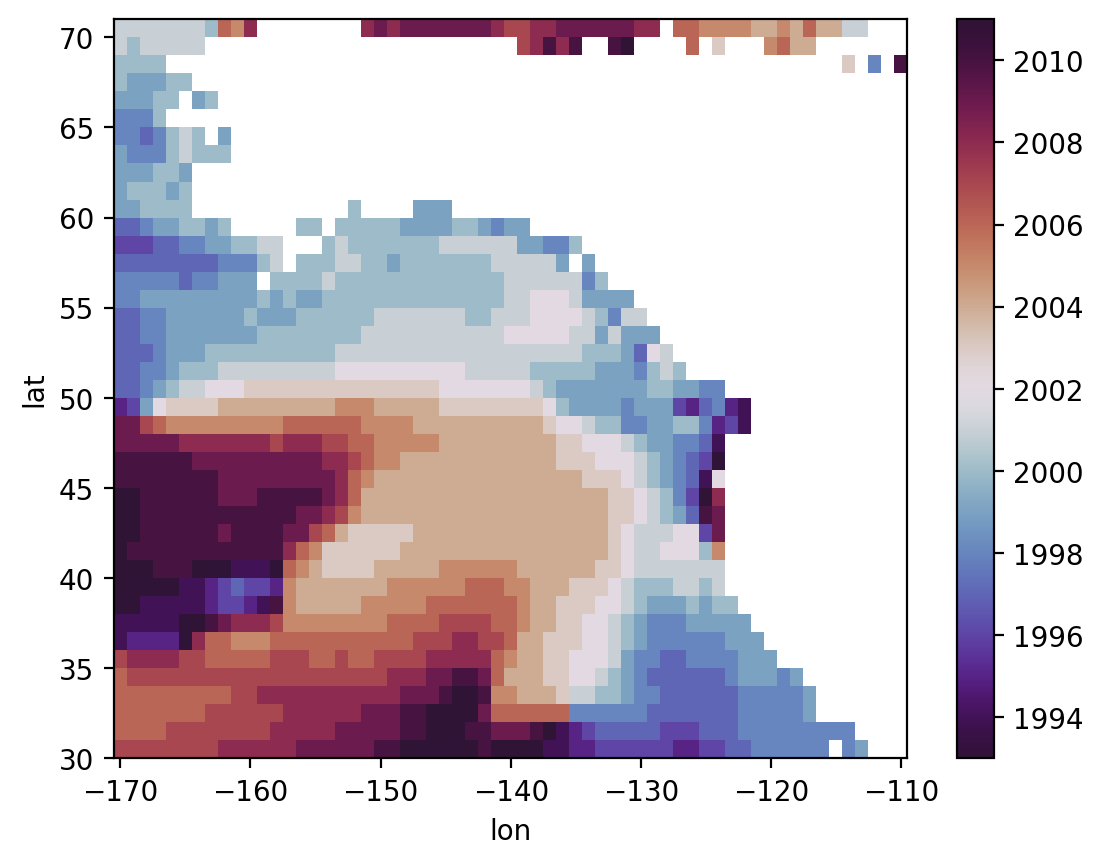

In [21]:
dampl = xr.DataArray(data=ampl,dims=["lat", "lon"],coords=dict(lon=(ster['lon']),
            lat=(ster['lat'])))
dphase = xr.DataArray(data=phase,dims=["lat", "lon"],coords=dict(lon=(ster['lon']),
            lat=(ster['lat'])))
dphase = xr.where(dphase == 0, np.nan, dphase)

dphase.plot(vmin=1993, vmax=2011,cmap='twilight_shifted'); 
#plt.savefig('/Users/sbult/Desktop/Scripts/data/StericDataSterre/NodalPhaseStericSeaLevel_EastPacific.png', dpi=150)

Cascais             2003.0
Brest               2002.0
Newlyn              2002.0
Vlissingen          2002.0
Hoek van Holland    2001.0
IJmuiden            2003.0
Den Helder          2002.0
Harlingen           2002.0
Delfzijl            2002.0
Cuxhaven            2003.0
Esbjerg             2002.0
North Shields       2002.0
Stavanger           2004.0
Bergen              2002.0
Name: dP (obs-eq), dtype: float64


TypeError: Length of x (0) must match number of columns in z (41)

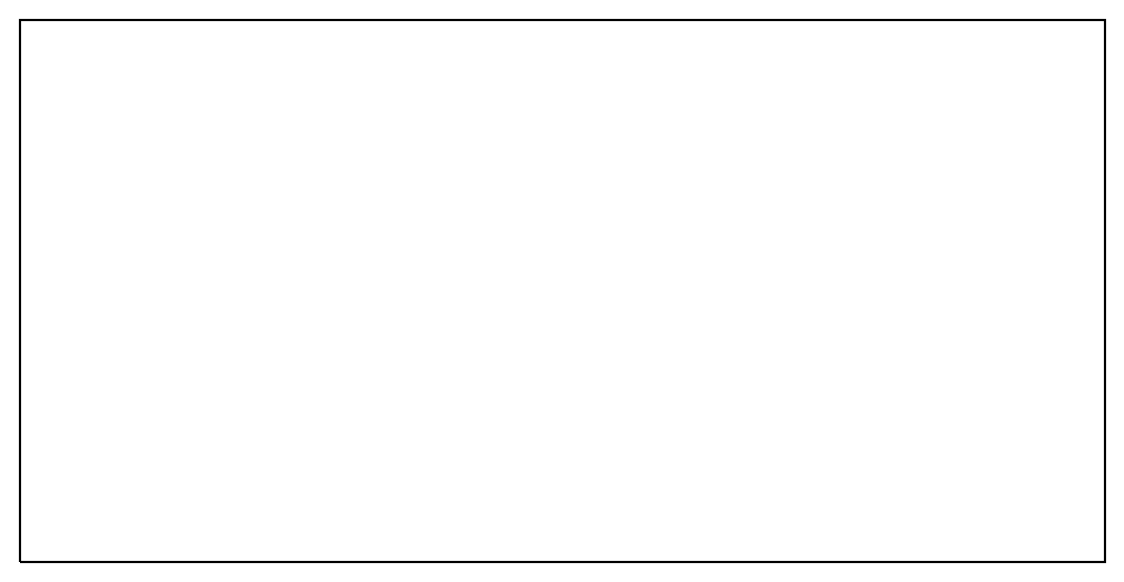

In [63]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable

from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

tg = pd.read_csv('/Users/sbult/Desktop/Scripts/data/tide gauges/tidegauges.csv',index_col=0)
tg_poe = tg['dP (obs-eq)']
tg_poe[0] = tg_poe[0]+18
print(tg_poe)

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())

min_lat = 30
max_lat = 71
min_lon = -170
max_lon = -110
density_ds2 = density_ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

lons = density_ds2['lon']
lats = density_ds2['lat']

dphase2 = dphase.interpolate_na(dim='lat')
dphase2 = dphase2.interpolate_na(dim='lon')

im = plt.contourf(lons, lats, dphase2, 60,transform=ccrs.PlateCarree(),cmap='twilight_shifted',antialiased=False,zorder=0)
#im = plt.pcolormesh(lons,lats,dphase2,transform=ccrs.PlateCarree(),cmap='twilight_shifted',shading='gouraud')

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
plt.colorbar(im,fraction=0.044, pad=0.001,ticks=np.arange(1993,2011,2),label='Time [year]')

ax.set_xticks([-20,-10,0,10,20], crs=ccrs.PlateCarree())
ax.set_yticks([30,40,50,60,70], crs=ccrs.PlateCarree())
ax.set_ylim([31,70])

#lats2 = [38.683333,48.382850,50.103000,51.442222,51.977500,52.462222,52.964444,53.18,53.326389,53.866667,55.460833,55.007444,58.974339,60.398046]
#lons2 = [-9.416667,-4.494838,-5.542833,3.596111,4.12000,4.554722,4.745000,5.409,6.933056,8.716667,8.441111,-1.439778,5.730121,5.320487]

s_ampl = tg_poe

im.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
im.axes.add_feature(cfeature.BORDERS)
im.axes.coastlines()

#plt.scatter(lons2,lats2,transform=ccrs.PlateCarree(),s=s_ampl/30,c=s_ampl,cmap='twilight_shifted',vmin=1993,vmax=2011,edgecolors='k',zorder=2);
#plt.savefig('/Users/sbult/Desktop/Scripts/data/StericDataSterre/NodalPhaseStericSeaLevel_v3.png', dpi=150)

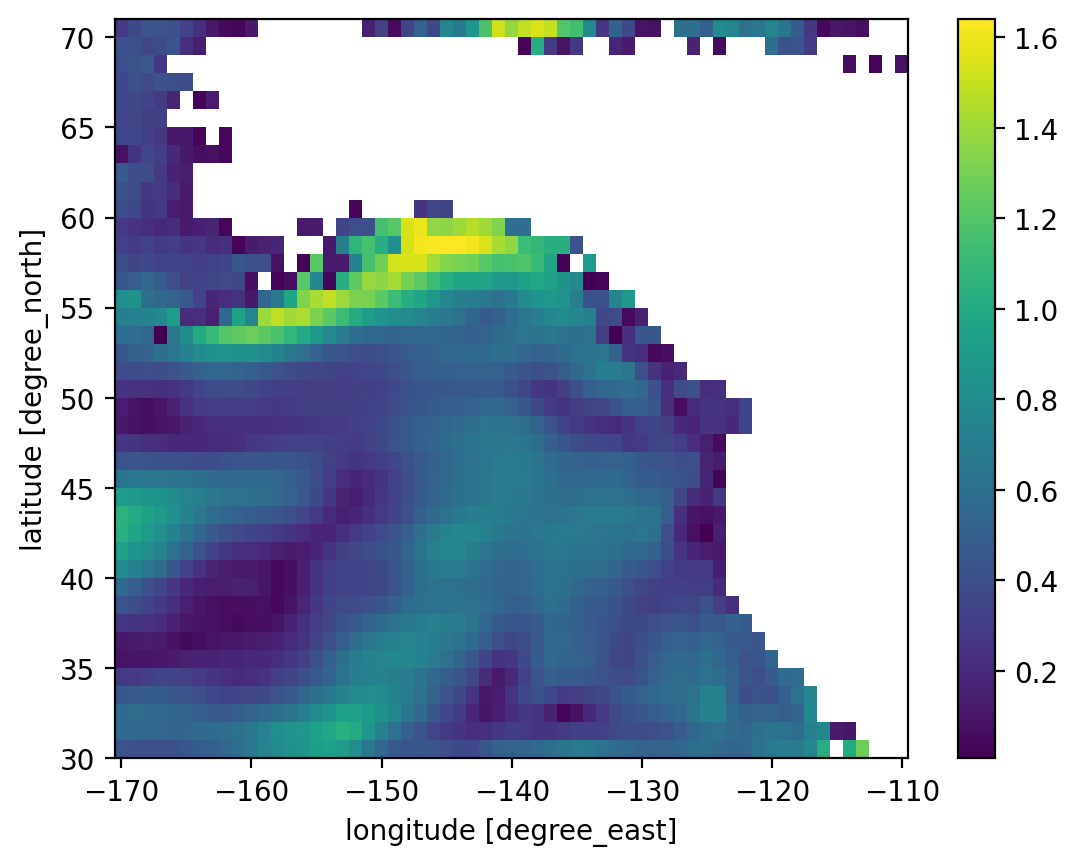

In [25]:
dampl.plot();
#plt.savefig('/Users/sbult/Desktop/Scripts/data/StericDataSterre/NodalAmplitudeStericSeaLevel_EastPacific.png', dpi=150)

TypeError: Length of x (0) must match number of columns in z (41)

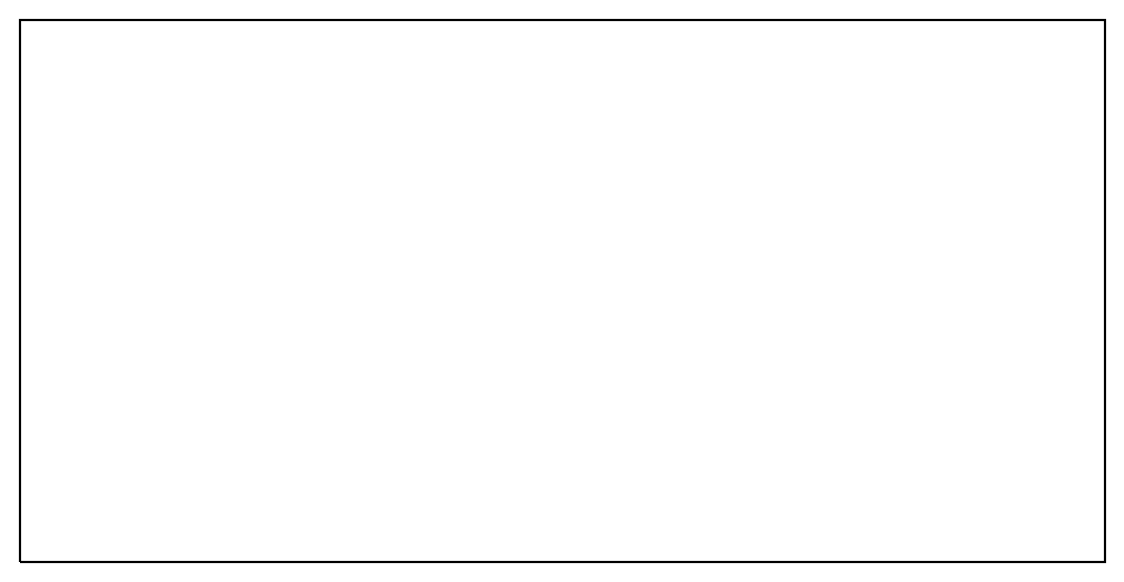

In [64]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())

dampl2 = dampl.interpolate_na(dim='lat')
dampl2 = dampl2.interpolate_na(dim='lon')

tg = pd.read_csv('/Users/sbult/Desktop/Scripts/data/tide gauges/tidegauges.csv',index_col=0)
tg_aoe = tg['dA (obs-eq)']

levels = np.linspace(0.0, 1.5,100)

im = plt.contourf(lons, lats, dampl2, 60,transform=ccrs.PlateCarree(),antialiased=False,levels=levels)

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
plt.colorbar(im,fraction=0.044, pad=0.001,label='Amplitude [cm]')

ax.set_xticks([-20,-10,0,10,20], crs=ccrs.PlateCarree())
ax.set_yticks([30,40,50,60,70], crs=ccrs.PlateCarree())
ax.set_ylim([31,70])

im.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
im.axes.add_feature(cfeature.BORDERS)
im.axes.coastlines();

s_ampl = tg_aoe

plt.scatter(lons2,lats2,transform=ccrs.PlateCarree(),s=s_ampl*40,c=s_ampl,vmin=0,vmax=1.5,edgecolors='k',zorder=2);
#plt.savefig('/Users/sbult/Desktop/Scripts/data/StericDataSterre/NodalAmplitudeStericSeaLevel_v3.png', dpi=150)

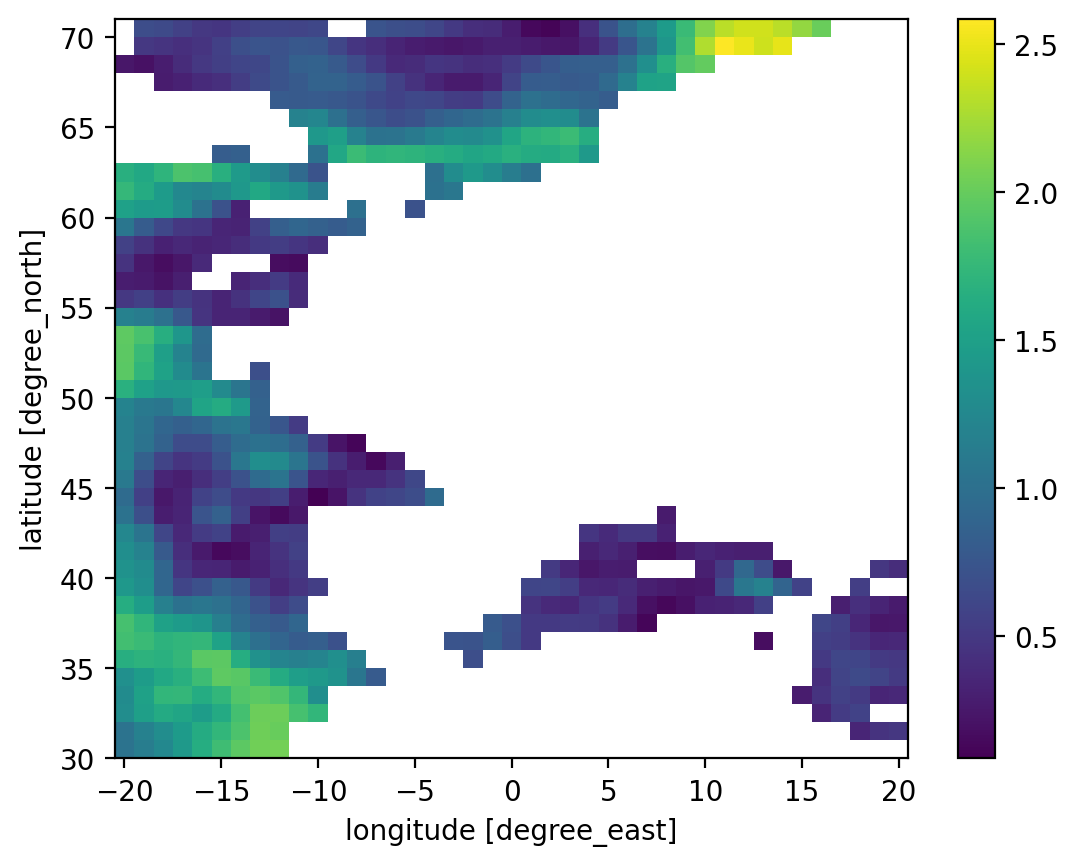

In [13]:
mean_ds = density_ds.density.sel(time=slice(1900,2020)).mean(dim='time')
mean_ds = mean_ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
a = xr.where(mean_ds[22,:,:].isnull(),np.nan,ampl)

mean_ampl = np.zeros((41,41))

for i in range(len(ster[1,:,1])):
    for j in range(len(ster[1,1,:])):
        LatIndexer, LonIndexer = 'lat', 'lon'
        min_lat = 30+i
        max_lat = 30+1+i
        min_lon = -20+j
        max_lon = -20+1+j
        values = np.array([min_lat,max_lat,min_lon,max_lon])
        
        SliceData = a.sel({'lat':slice(min_lat,max_lat),'lon':slice(min_lon,max_lon)})
        
        if SliceData.isnull().any() == True:
            SliceData = np.nan
        else:
            SliceData = SliceData.mean()
        
        mean_ampl[i,j] = SliceData

dmeanampl = xr.DataArray(data=mean_ampl,dims=["lat", "lon"],coords=dict(lon=(ster['lon']),
            lat=(ster['lat'])))
dmeanampl.plot();

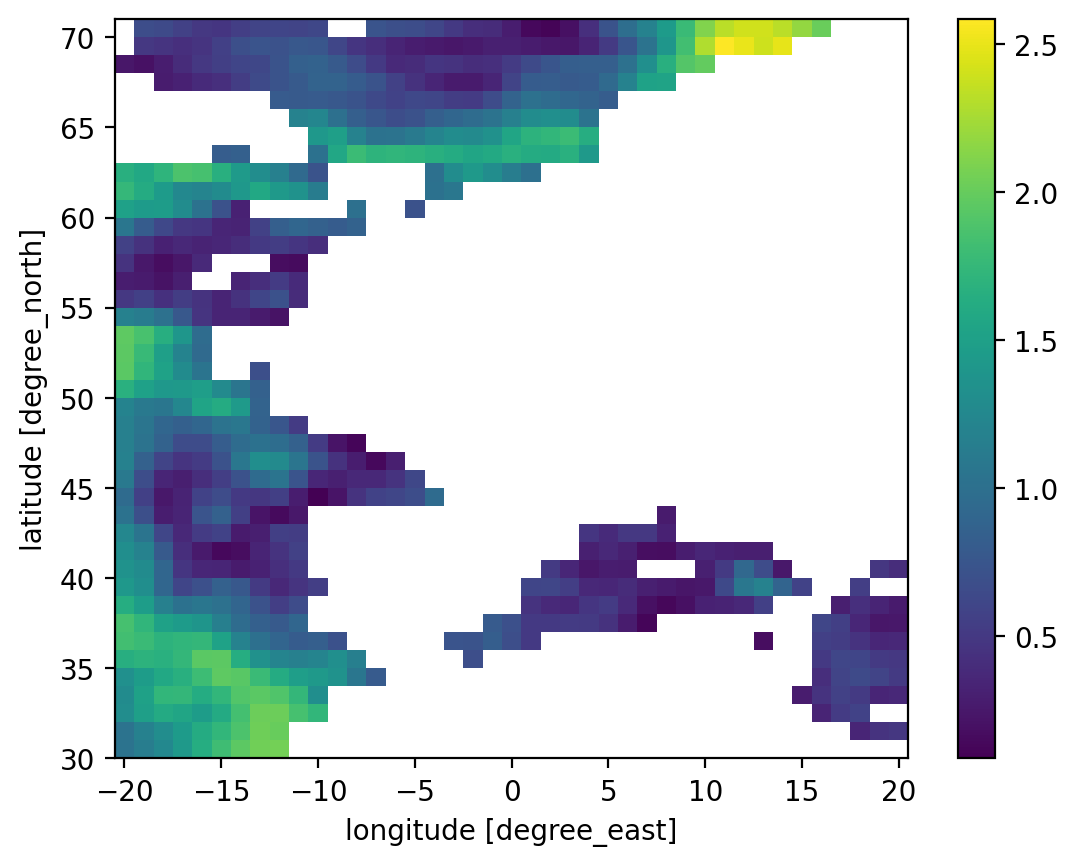

In [14]:
mean_ds = density_ds.density.sel(time=slice(1900,2020)).mean(dim='time')
mean_ds = mean_ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

dmeanampl = xr.DataArray(data=mean_ampl,dims=["lat", "lon"],coords=dict(lon=(ster['lon']),
            lat=(ster['lat'])))
dmeanampl.plot();

In [15]:
print(np.shape(mean_ampl))

(41, 41)


In [16]:
import geopy.distance

In [17]:
tg_id = [1]

coords_1 = np.zeros((41,41,2))
coords_2 = slc.tg_lat_lon(tg_id)
coords_2 = (int(coords_2[0]), int(coords_2[1]))
dist = np.zeros((41,41))

for i in range(len(ster[1,:,1])):
    for j in range(len(ster[1,1,:])):
        lat = dmeanampl['lat']
        lon = dmeanampl['lon']
        coords_1[i,j] = (lat[i], lon[j])
        
        dist[i,j] = geopy.distance.geodesic(coords_1[i,j,:], coords_2).km
        
        if np.isnan(mean_ampl[i,j]) == True:
            dist[i,j] = 9999
        else:
            dist[i,j] = dist[i,j]

print(dist.min())        
            
lat = ster['lat']
lon = ster['lon']

ri, ci = dist.argmin()//dist.shape[1], dist.argmin()%dist.shape[1]
print(lat[ri],lon[ci])

225.2225230298782
<xarray.DataArray 'lat' ()>
array(46.5, dtype=float32)
Coordinates:
    lat      float32 46.5
    depth    float32 1.0
Attributes:
    long_name:      latitude
    units:          degree_north
    standard_name:  latitude <xarray.DataArray 'lon' ()>
array(-6., dtype=float32)
Coordinates:
    lon      float32 -6.0
    depth    float32 1.0
Attributes:
    long_name:      longitude
    units:          degree_east
    standard_name:  longitude


In [18]:
reg_df = ster[20:,:,:]

reglat = reg_df['lat']
reglon = reg_df['lon']

t = ster['time']

reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)

min_lat = reglat[ri]
max_lat = reglat[ri]+1
min_lon = reglon[ci]
max_lon = reglon[ci]+1
values = np.array([min_lat,max_lat,min_lon,max_lon])
        
SliceData = reg_df.sel({'lat':slice(min_lat,max_lat),'lon':slice(min_lon,max_lon)}).mean(dim=['lat','lon'])
reg_df = SliceData.to_dataframe()

res_nr, res_full_nr = compute_model(reg_df)

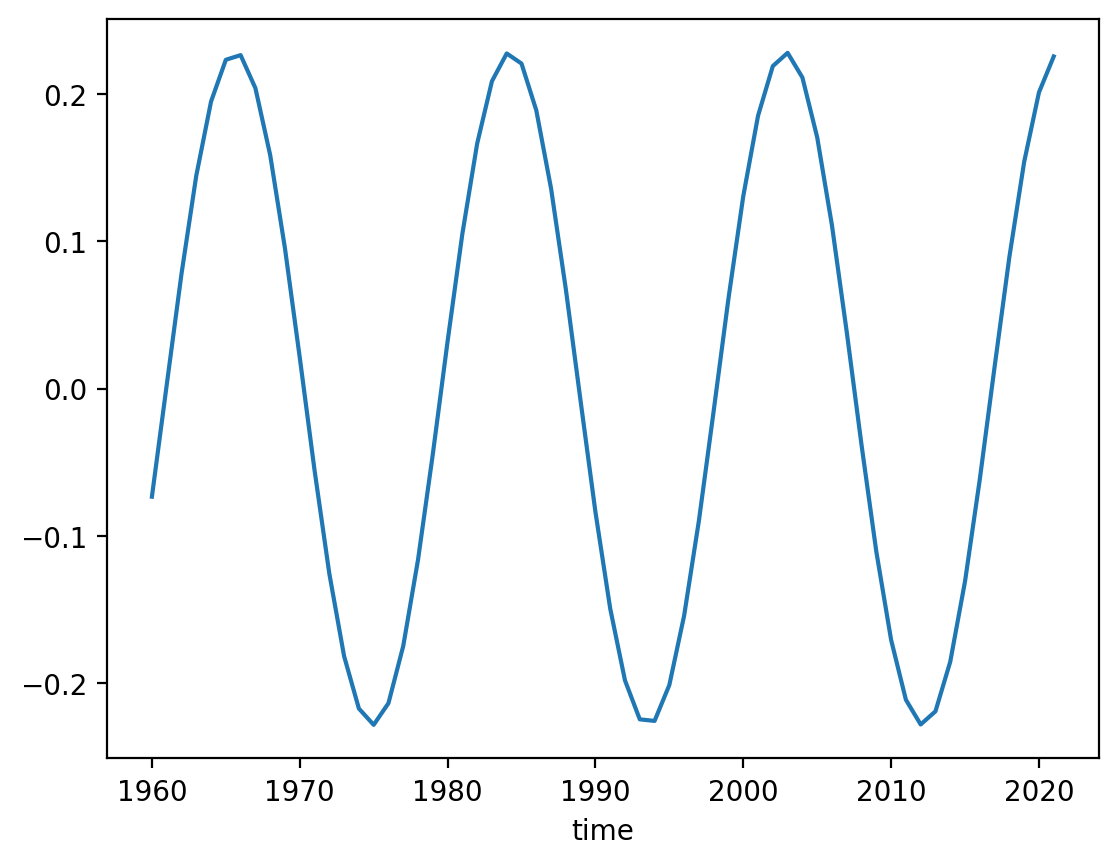

In [19]:
res_nr['nodal_steric'].plot();

In [8]:
density_ds = xr.open_dataset('/Users/sbult/Desktop/Scripts/data/StericDataSterre/DataSteric/density_teos10_en422_g10_1900_2022.nc')
#density_ds = xr.open_mfdataset('/Users/sbult/Desktop/Scripts/data/StericDataSterre/DataSteric/density_teos10_IAP/density_teos10_iap_*.nc')

print(density_ds)

ster = StericSL2('EN4_22',0,400,0)
ster = ster.loc[1960:]
print(t)

<xarray.Dataset>
Dimensions:  (depth: 42, lat: 41, lon: 41, time: 122)
Coordinates:
  * depth    (depth) float32 5.022 15.08 25.16 ... 4.752e+03 5.051e+03 5.35e+03
  * lat      (lat) float32 30.0 31.0 32.0 33.0 34.0 ... 66.0 67.0 68.0 69.0 70.0
  * lon      (lon) float32 -20.0 -19.0 -18.0 -17.0 -16.0 ... 17.0 18.0 19.0 20.0
  * time     (time) int64 1900 1901 1902 1903 1904 ... 2017 2018 2019 2020 2021
Data variables:
    density  (time, depth, lat, lon) float64 ...
    alpha    (time, depth, lat, lon) float64 ...
    beta     (time, depth, lat, lon) float64 ...
<xarray.DataArray 'time' (time: 62)>
array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,

In [9]:
from sklearn.metrics import mean_squared_error
import math

ampl = np.zeros((len(ster[1,:,1]),len(ster[1,1,:])))
phase = np.zeros((len(ster[1,:,1]),len(ster[1,1,:])))
RMSE = np.zeros((len(ster[1,:,1]),len(ster[1,1,:])))

for i in range(len(ster[1,:,1])):
    for j in range(len(ster[1,1,:])):
        if ster[:,i,j].isnull().values.any() == False:
            reg_df = ster[:,i,j].to_dataframe()
            t = ster['time']

            reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
            reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)
        
            res_nr, res_full_nr = compute_model(reg_df)
            
            ampl[i,j] = res_nr["nodal_steric"].loc[1993:2011].max()
            phase[i,j] = res_nr["nodal_steric"].loc[1993:2011].idxmax()
            MSE = mean_squared_error(ster[:,i,j], res_nr['total'])
            RMSE[i,j] = math.sqrt(MSE)
        else: 
            ampl[i,j] = 'NaN'
            RMSE[i,j] = 'NaN'

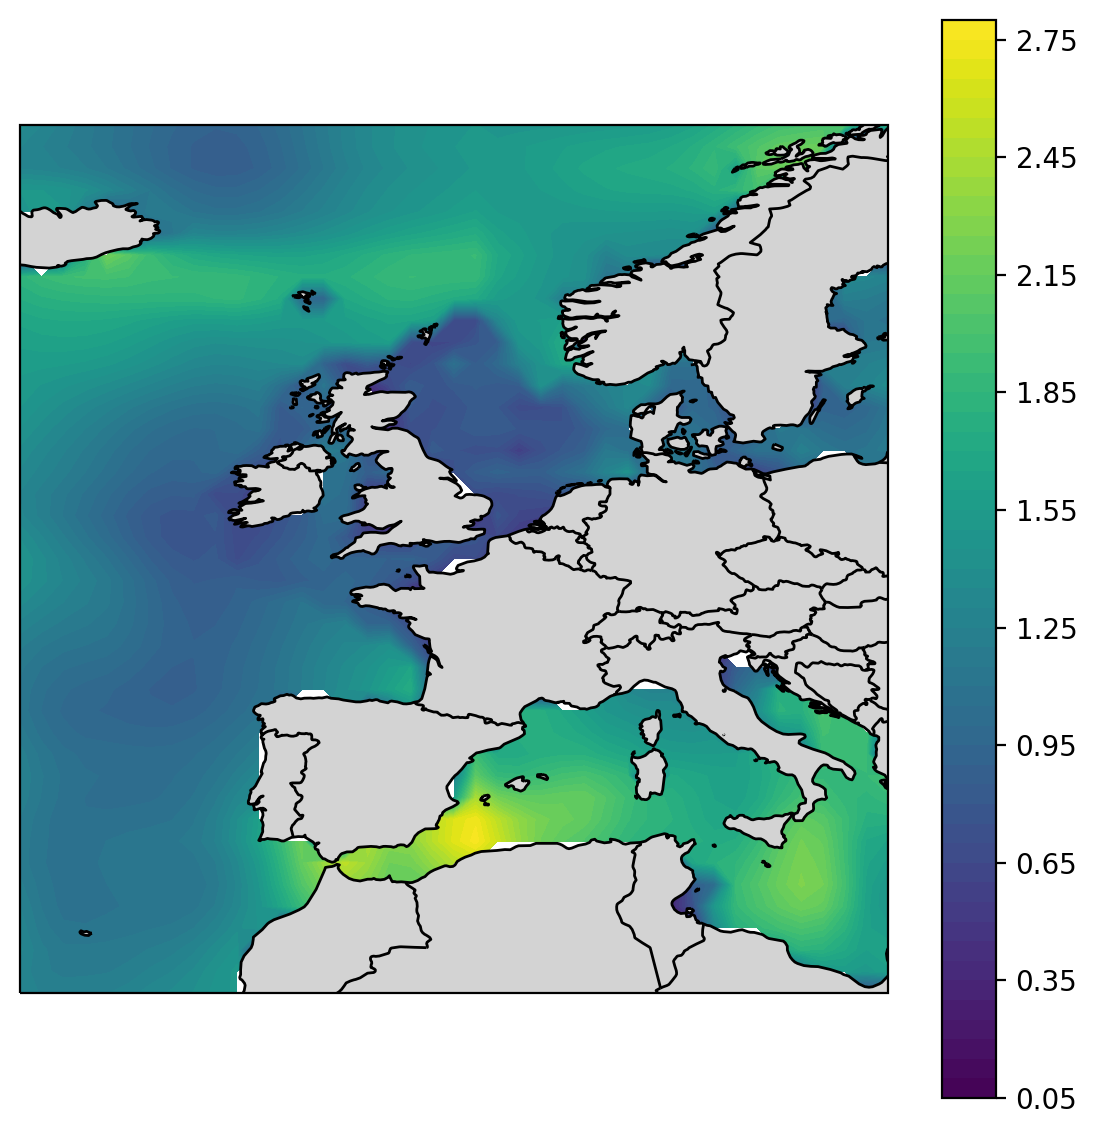

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable

from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())

lons = density_ds['lon']
lats = density_ds['lat']

im = plt.contourf(lons, lats, RMSE, 60,transform=ccrs.PlateCarree(),antialiased=False,zorder=0)
plt.colorbar();

im.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
im.axes.add_feature(cfeature.BORDERS)
im.axes.coastlines();

In [17]:
density_ds2 = xr.open_mfdataset('/Users/sbult/Desktop/Scripts/data/StericDataSterre/DataSteric/density_teos10_IAP/density_teos10_iap_*.nc')

ster2 = StericSL2('IAP',0,500,0)
min_lat = 30
max_lat = 71
min_lon = -20
max_lon = 20
ster2 = ster2.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
t = ster['time']

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.


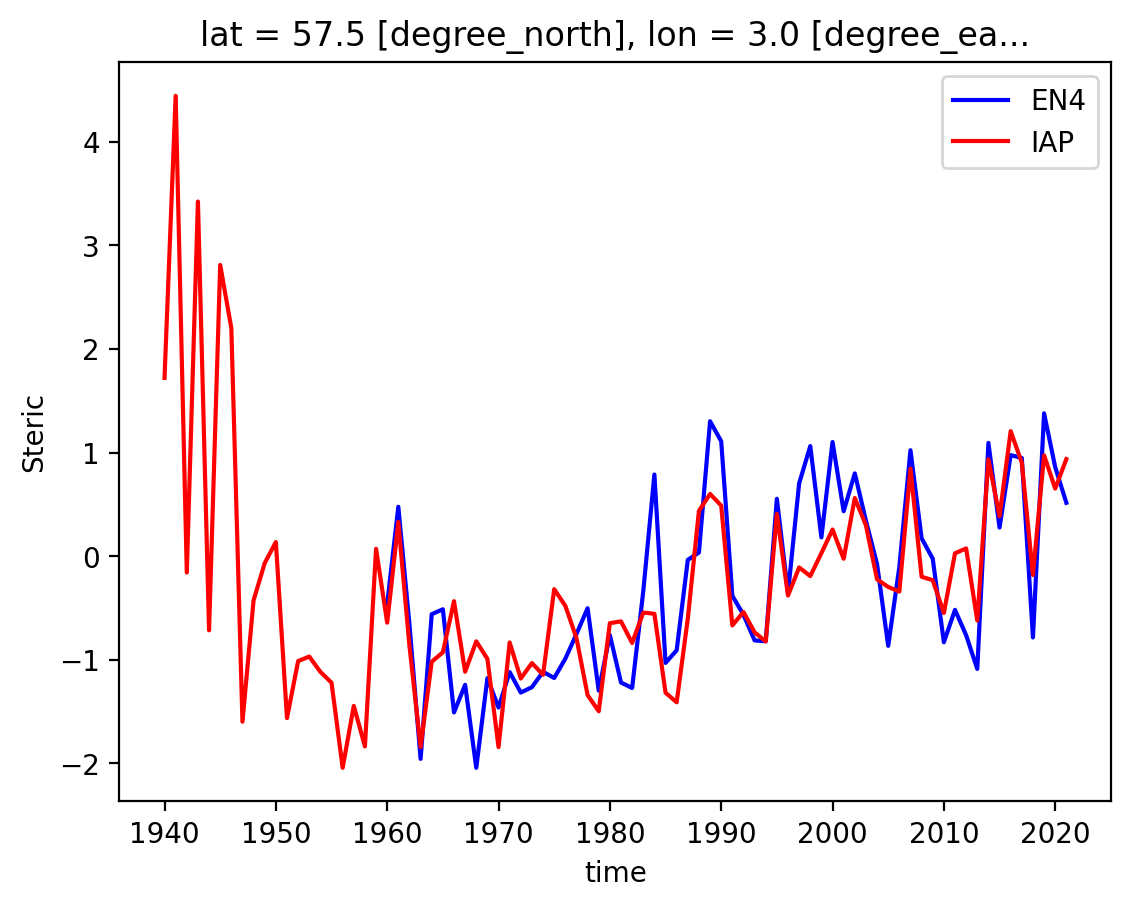

In [18]:
lats = 57
lons = 3

sl1 = ster.sel(lat=lats,lon=lons,method='nearest')
sl2 = ster2.sel(lat=lats,lon=lons,method='nearest')

sl1.plot(color='b',label='EN4')
sl2.plot(color='r',label='IAP')
plt.legend();

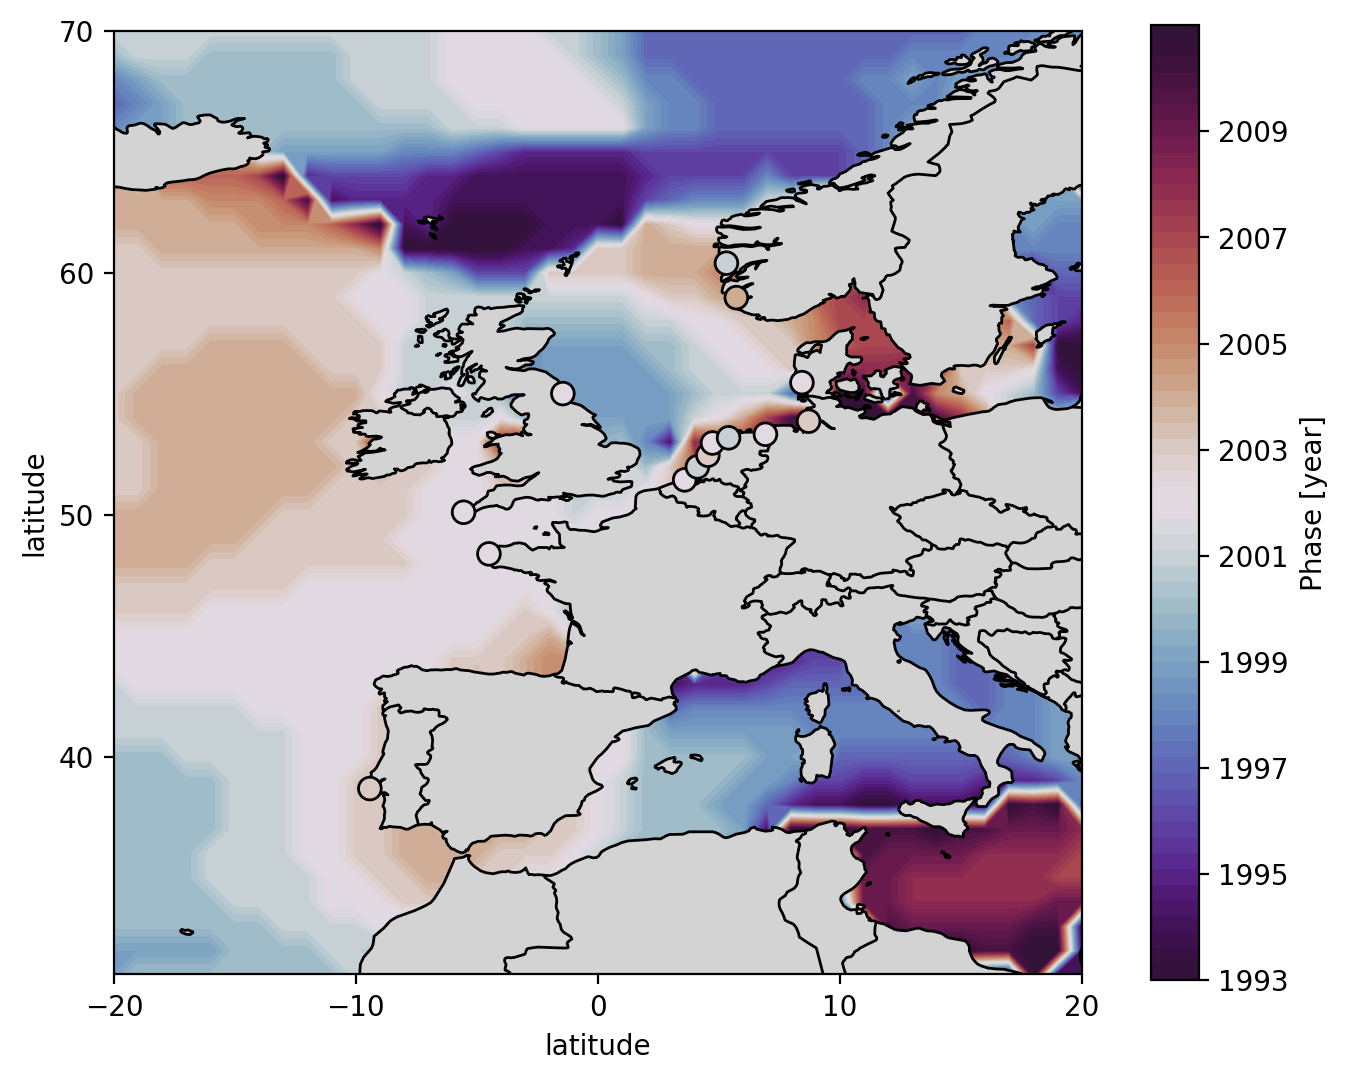

In [12]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable

dampl = xr.DataArray(data=ampl,dims=["lat", "lon"],coords=dict(lon=(ster['lon']),
            lat=(ster['lat'])))
dphase = xr.DataArray(data=phase,dims=["lat", "lon"],coords=dict(lon=(ster['lon']),
            lat=(ster['lat'])))

dphase = xr.where(dphase == 0, np.nan, dphase)

tg = pd.read_csv('/Users/sbult/Desktop/Scripts/data/tide gauges/tidegauges_v13.csv',index_col=0)
tg_poe = tg['dP (obs-eq)']
tg_poe[0] = tg_poe[0]

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())

min_lat = 30
max_lat = 71
min_lon = -20
max_lon = 20
density_ds2 = density_ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

lons = density_ds2['lon']
lats = density_ds2['lat']

dphase2 = dphase.interpolate_na(dim='lat')
dphase2 = dphase2.interpolate_na(dim='lon')

im = plt.contourf(lons, lats, dphase2, 60,transform=ccrs.PlateCarree(),cmap='twilight_shifted',antialiased=False,zorder=0)
#im = plt.pcolormesh(lons,lats,dphase2,transform=ccrs.PlateCarree(),cmap='twilight_shifted',shading='gouraud')

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
plt.colorbar(im,fraction=0.044, pad=0.001,ticks=np.arange(1993,2011,2),label='Phase [year]')

ax.set_xticks([-20,-10,0,10,20], crs=ccrs.PlateCarree())
ax.set_yticks([30,40,50,60,70], crs=ccrs.PlateCarree())
ax.set_ylim([31,70])

lats2 = [38.683333,48.382850,50.103000,51.442222,51.977500,52.462222,52.964444,53.18,53.326389,53.866667,55.460833,55.007444,58.974339,60.398046]
lons2 = [-9.416667,-4.494838,-5.542833,3.596111,4.12000,4.554722,4.745000,5.409,6.933056,8.716667,8.441111,-1.439778,5.730121,5.320487]

s_ampl = tg_poe

im.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
im.axes.add_feature(cfeature.BORDERS)
im.axes.coastlines()

ax.set_ylabel('latitude')
ax.set_xlabel('latitude')

plt.scatter(lons2,lats2,transform=ccrs.PlateCarree(),s=s_ampl/30,c=s_ampl,cmap='twilight_shifted',vmin=1993,vmax=2011,edgecolors='k',zorder=2);
#plt.savefig('/Users/sbult/Desktop/Scripts/data/StericDataSterre/NodalPhaseStericSeaLevel_v4_EN4_latlon.png', dpi=150)

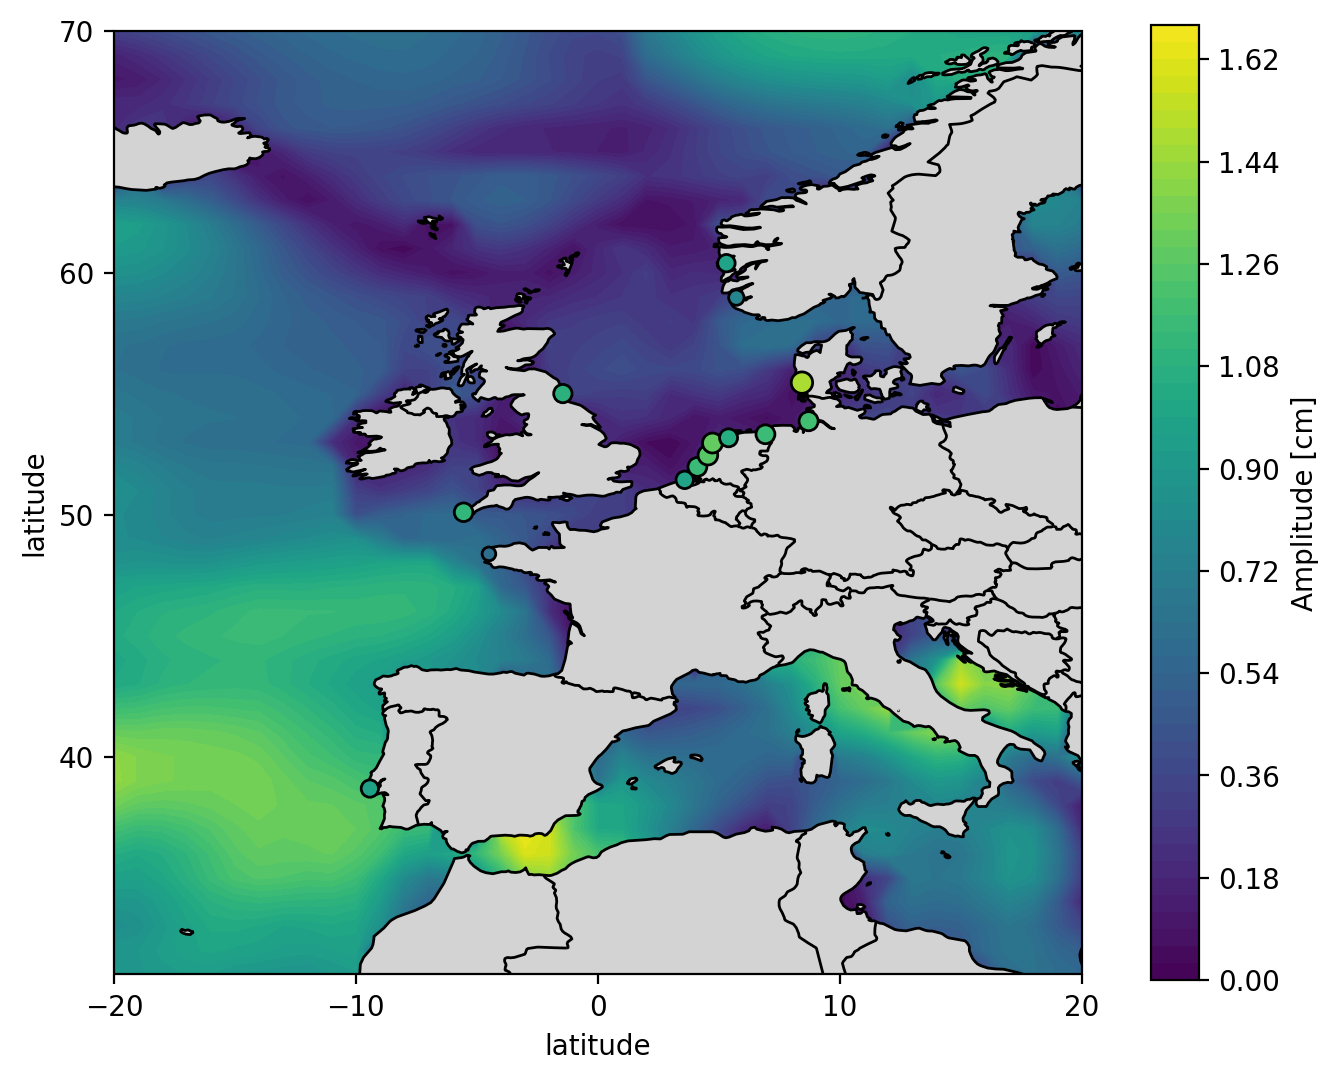

In [13]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())

dampl2 = dampl.interpolate_na(dim='lat')
dampl2 = dampl2.interpolate_na(dim='lon')

tg = pd.read_csv('/Users/sbult/Desktop/Scripts/data/tide gauges/tidegauges_v13.csv',index_col=0)
tg_aoe = tg['dA (obs-eq)']

im = plt.contourf(lons, lats, dampl2, 60,transform=ccrs.PlateCarree(),vmin=0,vmax=1.7,antialiased=False)

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
plt.colorbar(im,fraction=0.044, pad=0.001,label='Amplitude [cm]')

ax.set_xticks([-20,-10,0,10,20], crs=ccrs.PlateCarree())
ax.set_yticks([30,40,50,60,70], crs=ccrs.PlateCarree())
ax.set_ylim([31,70])

im.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
im.axes.add_feature(cfeature.BORDERS)
im.axes.coastlines();

s_ampl = tg_aoe

ax.set_ylabel('latitude')
ax.set_xlabel('latitude')

plt.scatter(lons2,lats2,transform=ccrs.PlateCarree(),s=s_ampl*40,c=s_ampl,vmin=0,vmax=1.7,edgecolors='k',zorder=2);
#plt.savefig('/Users/sbult/Desktop/Scripts/data/StericDataSterre/NodalAmplitudeStericSeaLevel_v4_EN4_latlon.png', dpi=150)

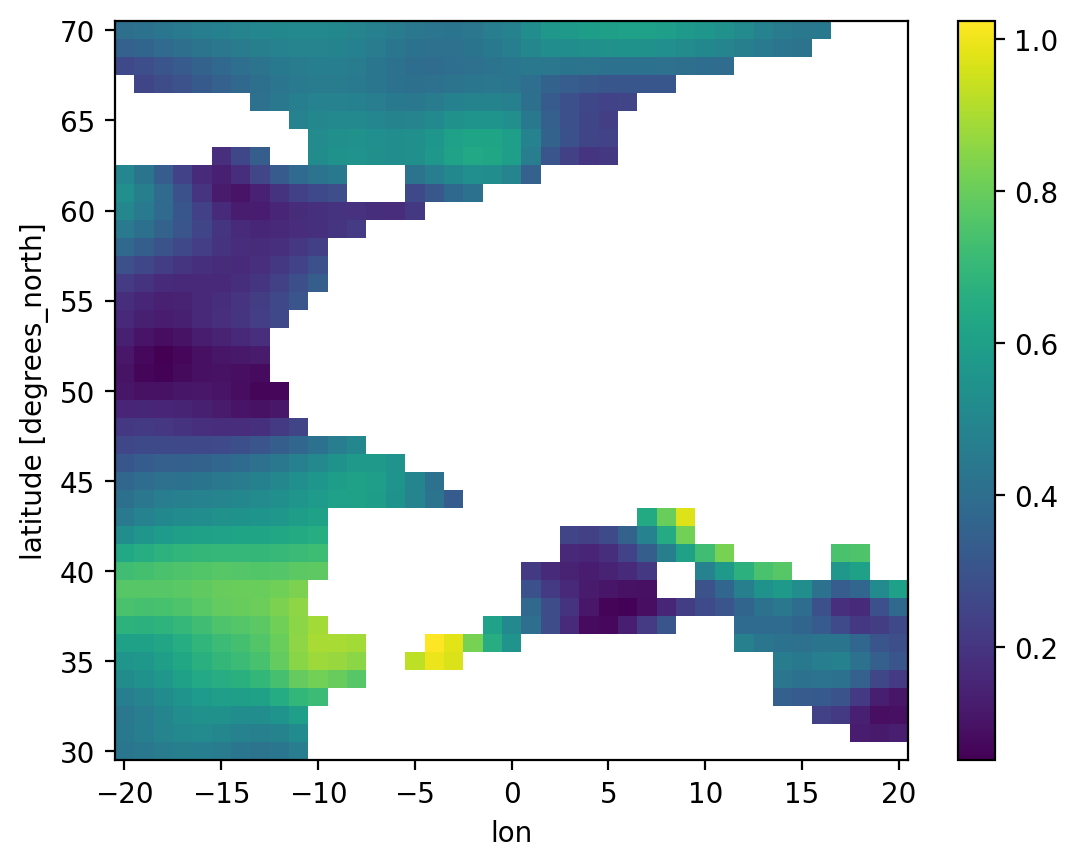

In [90]:
mean_ds = density_ds.density.sel(time=slice(1900,2020)).mean(dim='time')
a = xr.where(mean_ds[22,:,:].isnull(),np.nan,ampl)

mean_ampl = np.zeros((41,41))

for i in range(len(ster[1,:,1])):
    for j in range(len(ster[1,1,:])):
        LatIndexer, LonIndexer = 'lat', 'lon'
        min_lat = 30+i
        max_lat = 30+1+i
        min_lon = -20+j
        max_lon = -20+1+j
        values = np.array([min_lat,max_lat,min_lon,max_lon])
        
        SliceData = a.sel({'lat':slice(min_lat,max_lat),'lon':slice(min_lon,max_lon)})
        
        if SliceData.isnull().any() == True:
            SliceData = np.nan
        else:
            SliceData = SliceData.mean()
        
        mean_ampl[i,j] = SliceData

dmeanampl = xr.DataArray(data=mean_ampl,dims=["lat", "lon"],coords=dict(lon=(ster['lon']),
            lat=(ster['lat'])))
dmeanampl.plot();

In [18]:
ster = ster.sel(time=slice(1940,2021))
reg_df = ster[:,33,30].to_dataframe()
t = ster['time']

reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)
        
res_nr, res_full_nr = compute_model(reg_df)

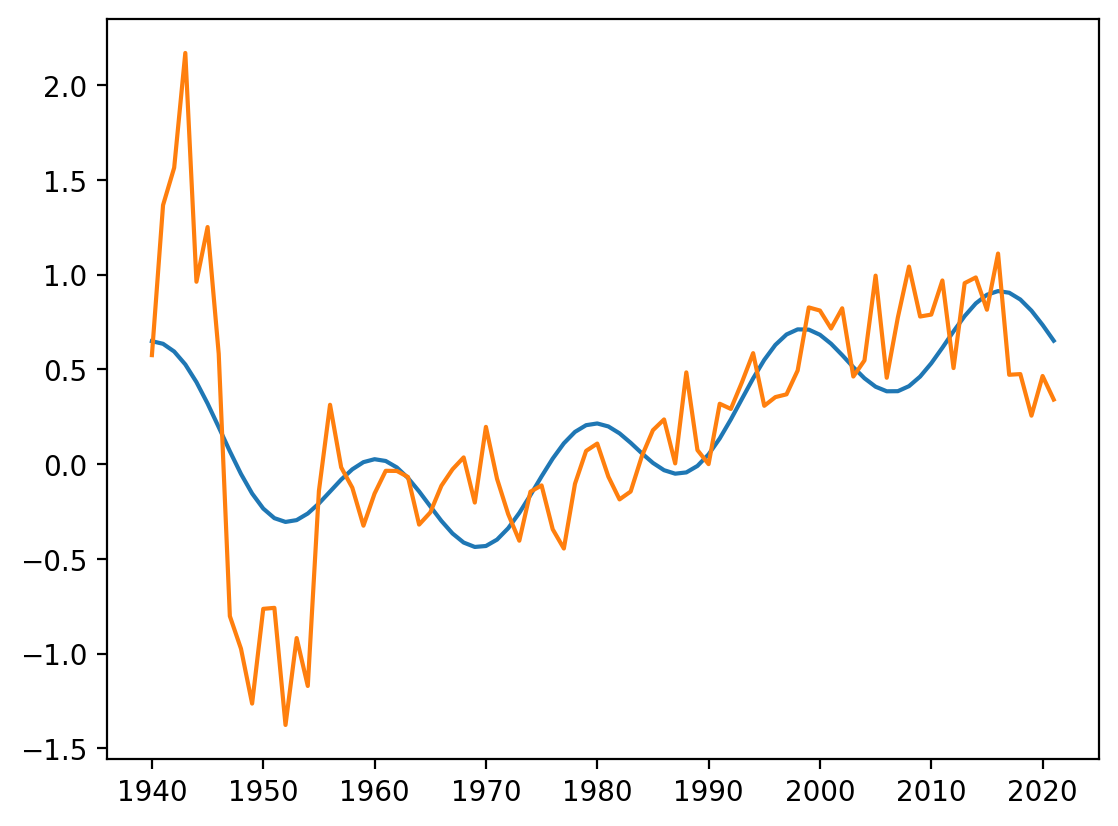

In [20]:
plt.plot(res_nr["total"]);
plt.plot(reg_df['Steric']);
plt.savefig('/Users/sbult/Desktop/Scripts/data/StericDataSterre/BalticSeaStericSeaLevel.pdf', dpi=150)

In [76]:
#density_ds = xr.open_dataset('/Users/sbult/Desktop/Scripts/data/StericDataSterre/DataSteric/density_teos10_en422_g10_1900_2022.nc')
density_ds = xr.open_mfdataset('/Users/sbult/Desktop/Scripts/data/StericDataSterre/DataSteric/density_teos10_IAP/density_teos10_iap_*.nc')

ster = StericSL2('IAP',0,max_depth,0)
min_lat = 30
max_lat = 71
min_lon = -20
max_lon = 20
ster = ster.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
t = ster['time']

In [94]:
reg_df = ster[:,33,30].to_dataframe()
t = ster['time']

reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)
        
res_nr, res_full_nr = compute_model(reg_df)

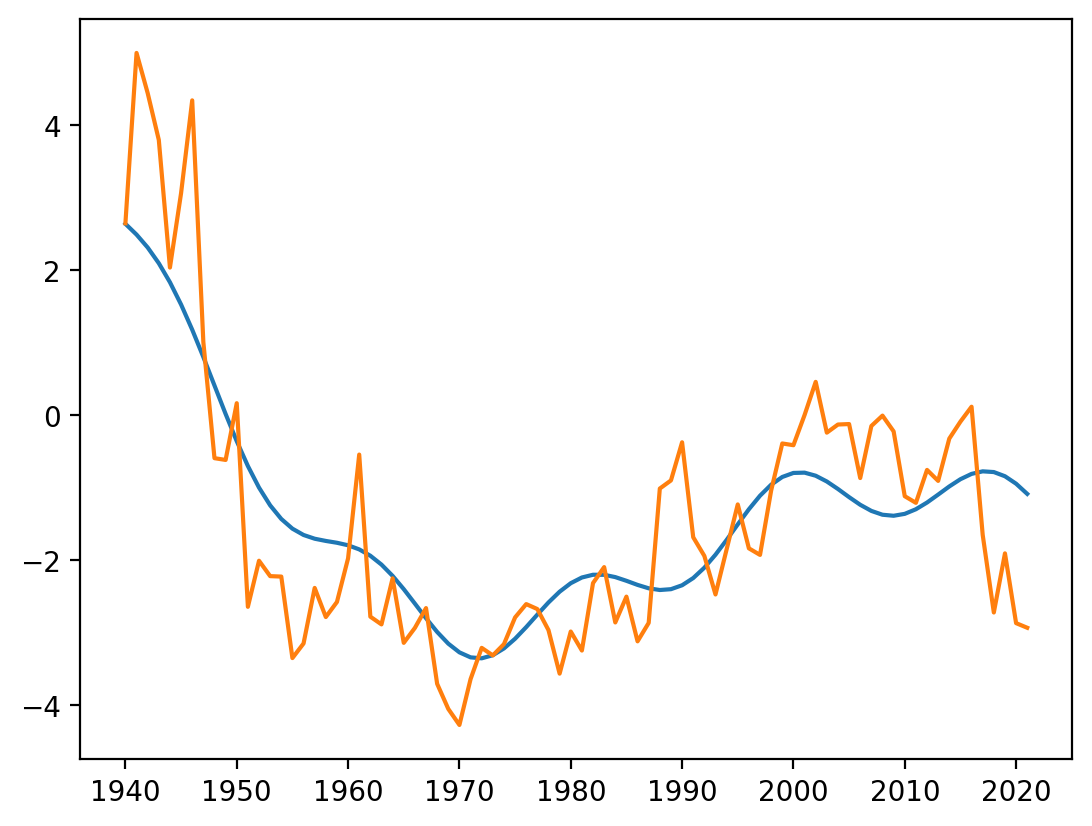

In [95]:
plt.plot(res_nr["total"]);
plt.plot(reg_df['Steric']);

In [168]:
ster2 = ster.sel(time=slice(1940,2021))
reg_df = ster2.sel(lat=slice(50,55),lon=slice(3,8)).mean(dim=['lat','lon'])
reg_df = reg_df.to_dataframe()

t = ster['time']

reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)
        
res_nr, res_full_nr = compute_model(reg_df)

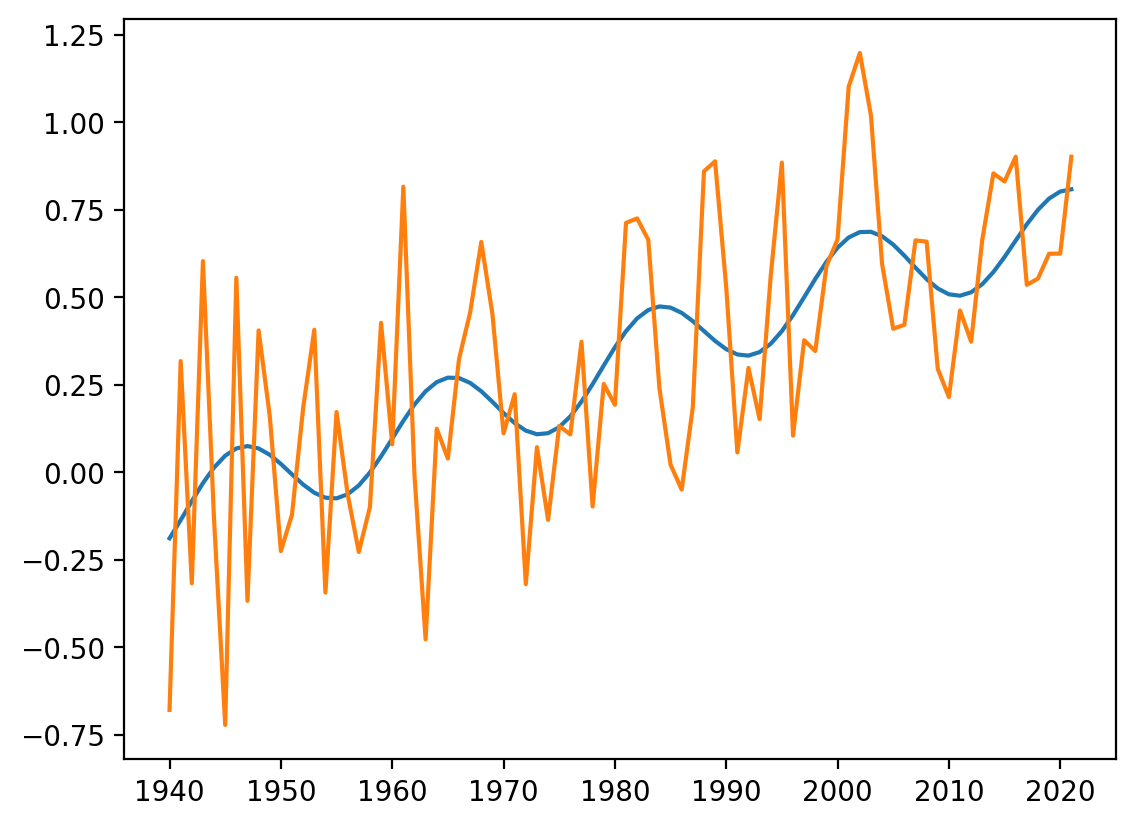

In [169]:
plt.plot(res_nr["total"]);
plt.plot(reg_df['Steric']);

In [171]:
ster = ster.sel(time=slice(1940,2021))
reg_df = ster[:,23,25].to_dataframe()

t = ster['time']

reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)
        
res_nr, res_full_nr = compute_model(reg_df)

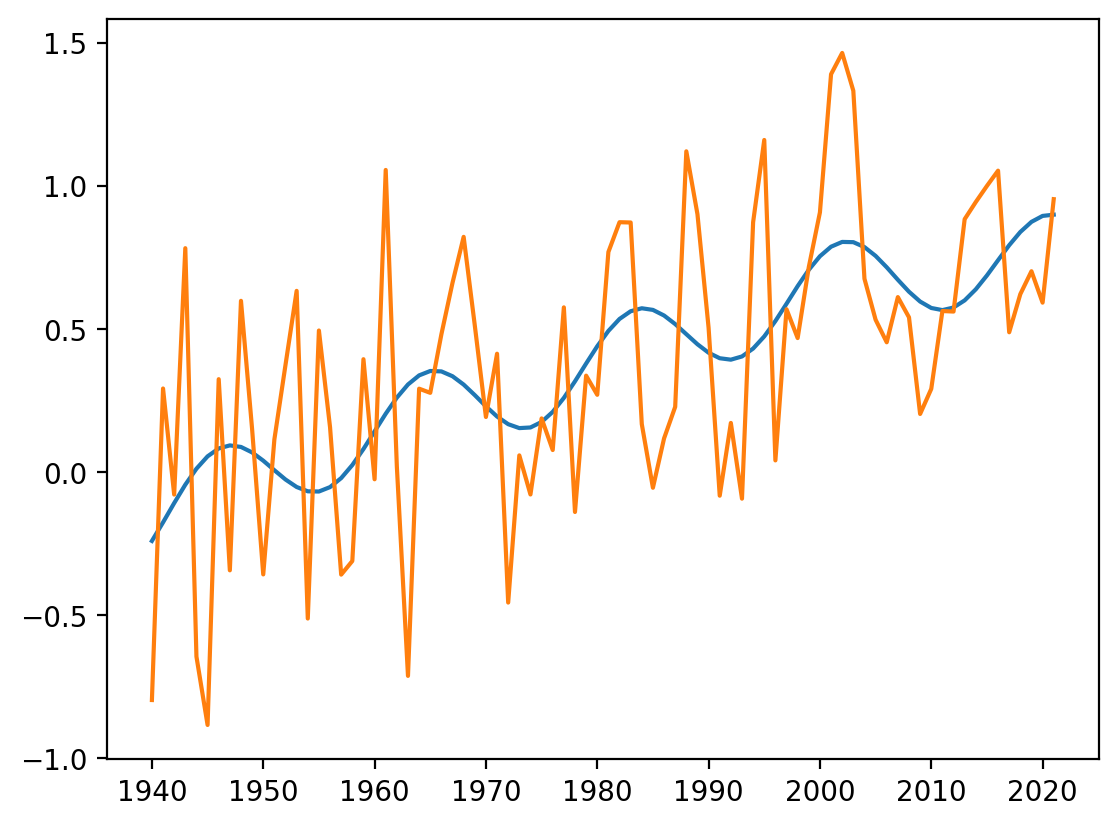

In [172]:
plt.plot(res_nr["total"]);
plt.plot(reg_df['Steric']);

In [293]:
check = xr.open_dataset('/Users/sbult/Desktop/Scripts/data/StericDataSterre/EN/EN.4.2.1.f.profiles.g10.190001.nc')

In [100]:
dampl = xr.open_dataset('/Users/sbult/Desktop/Scripts/data/altimetry/ampl_altimetry.nc')
print(dampl)

<xarray.Dataset>
Dimensions:                        (longitude: 40, latitude: 40)
Coordinates:
    lon                            (longitude) float64 ...
    lat                            (latitude) float64 ...
Dimensions without coordinates: longitude, latitude
Data variables:
    __xarray_dataarray_variable__  (latitude, longitude) float64 ...


TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_array()` method.

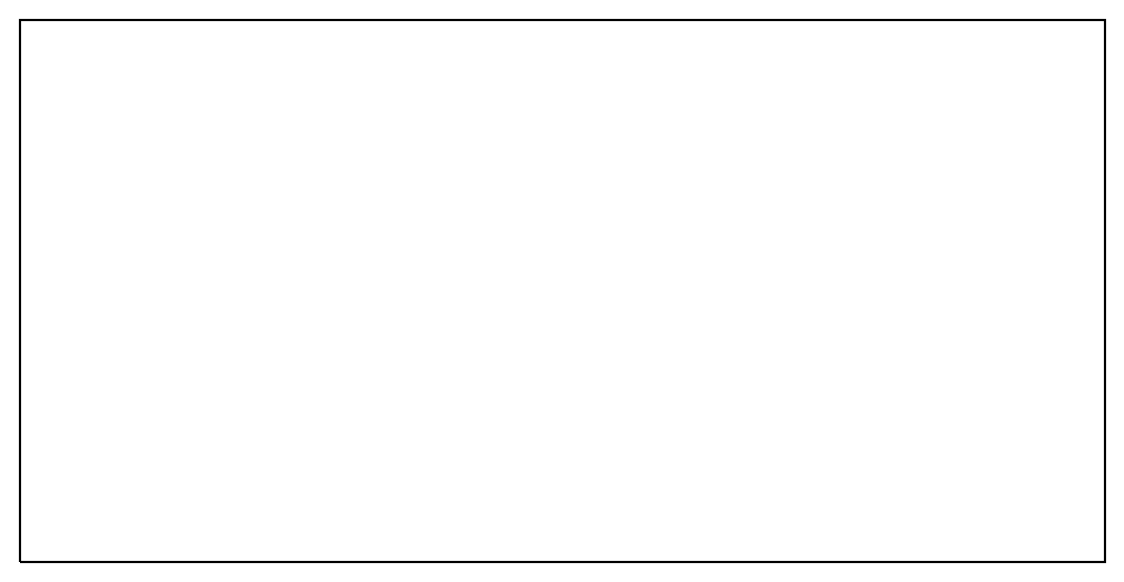

In [101]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())

dampl2 = dampl.interpolate_na(dim='lat')
dampl2 = dampl2.interpolate_na(dim='lon')

lons = density_ds2['lon']
lats = density_ds2['lat']

tg = pd.read_csv('/Users/sbult/Desktop/Scripts/data/tide gauges/tidegauges.csv',index_col=0)
tg_aoe = tg['dA (obs-eq)']

im = plt.contourf(lons, lats, dampl2, transform=ccrs.PlateCarree())

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
plt.colorbar(im,fraction=0.044, pad=0.001,label='Amplitude [cm]')

ax.set_xticks([-20,-10,0,10,20], crs=ccrs.PlateCarree())
ax.set_yticks([30,40,50,60,70], crs=ccrs.PlateCarree())
ax.set_ylim([31,70])

im.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
im.axes.add_feature(cfeature.BORDERS)
im.axes.coastlines();

s_ampl = tg_aoe

plt.scatter(lons2,lats2,transform=ccrs.PlateCarree(),s=s_ampl*40,c=s_ampl,vmin=0,vmax=1.4,edgecolors='k',zorder=2);
#plt.savefig('/Users/sbult/Desktop/Scripts/data/StericDataSterre/NodalAmplitudeStericSeaLevel_v4_EN4.png', dpi=150)

In [8]:
density_ds = xr.open_dataset('/Users/sbult/Desktop/Scripts/data/StericDataSterre/DataSteric/density_teos10_en422_g10_1900_2022.nc')
density_ds_iap = xr.open_mfdataset('/Users/sbult/Desktop/Scripts/data/StericDataSterre/DataSteric/density_teos10_IAP/density_teos10_iap_*.nc')

In [9]:
print(density_ds)
depth = density_ds['depth']

<xarray.Dataset>
Dimensions:  (depth: 42, lat: 41, lon: 41, time: 122)
Coordinates:
  * depth    (depth) float32 5.022 15.08 25.16 ... 4.752e+03 5.051e+03 5.35e+03
  * lat      (lat) float32 30.0 31.0 32.0 33.0 34.0 ... 66.0 67.0 68.0 69.0 70.0
  * lon      (lon) float32 -20.0 -19.0 -18.0 -17.0 -16.0 ... 17.0 18.0 19.0 20.0
  * time     (time) int64 1900 1901 1902 1903 1904 ... 2017 2018 2019 2020 2021
Data variables:
    density  (time, depth, lat, lon) float64 ...
    alpha    (time, depth, lat, lon) float64 ...
    beta     (time, depth, lat, lon) float64 ...


In [10]:
density = density_ds['density']
density_iap = density_ds_iap['density']
print(density)

<xarray.DataArray 'density' (time: 122, depth: 42, lat: 41, lon: 41)>
[8613444 values with dtype=float64]
Coordinates:
  * depth    (depth) float32 5.022 15.08 25.16 ... 4.752e+03 5.051e+03 5.35e+03
  * lat      (lat) float32 30.0 31.0 32.0 33.0 34.0 ... 66.0 67.0 68.0 69.0 70.0
  * lon      (lon) float32 -20.0 -19.0 -18.0 -17.0 -16.0 ... 17.0 18.0 19.0 20.0
  * time     (time) int64 1900 1901 1902 1903 1904 ... 2017 2018 2019 2020 2021
Attributes:
    long_name:  in-situ density
    units:      kg/m3


/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


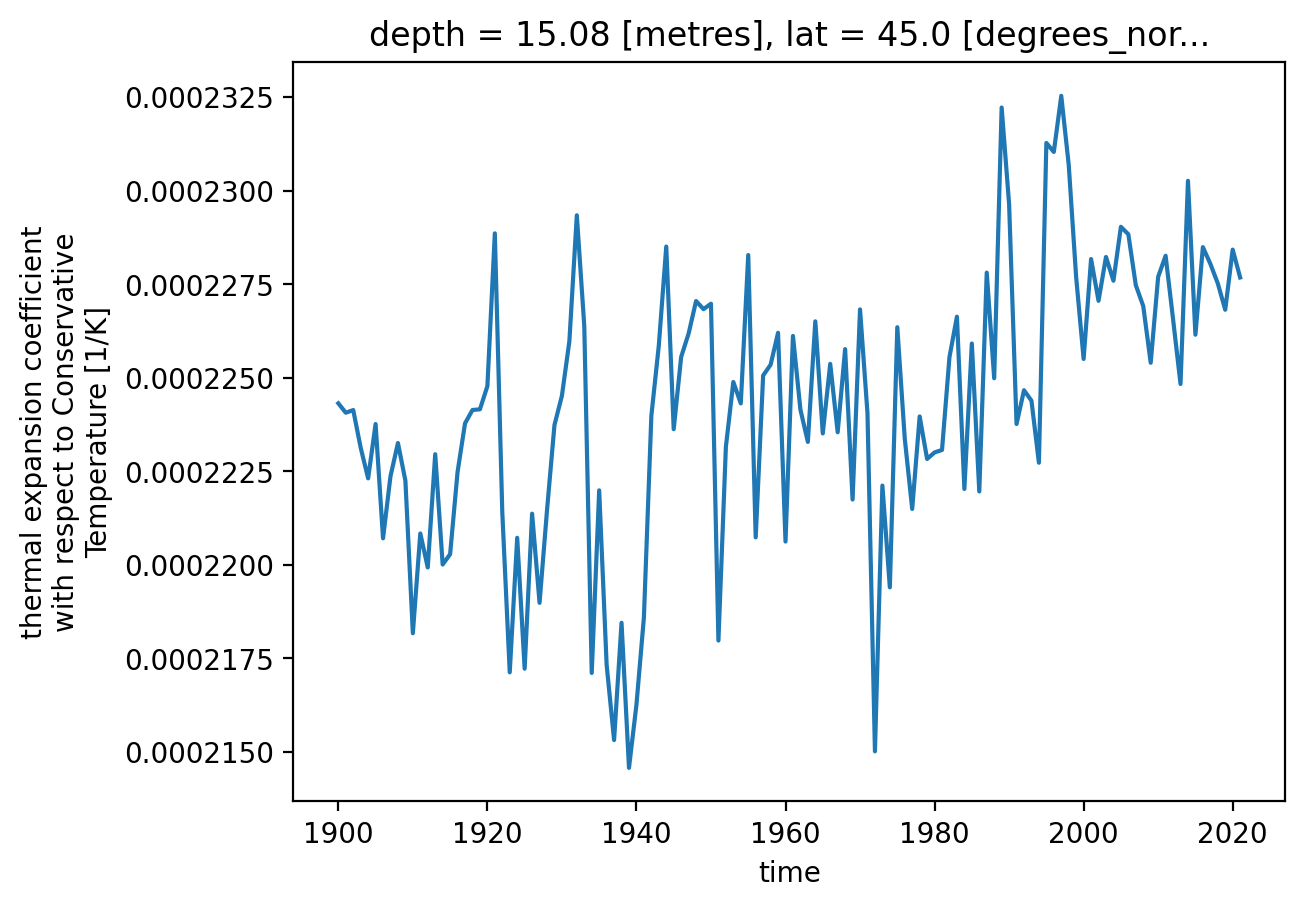

In [11]:
#for i in range(10):
    #density[i+10,:,40,10].plot(label=i+1);
#density[80:122,7,30,10].plot()
density_ds.alpha[:,1,15,10].plot()
#density_ds.beta[1,:,15,10].plot()
#density_iap[1,:,15,10].plot()
##plt.legend(loc='upper right');
#plt.xlim([0,1000])
#plt.ylim([1027.4,1027.8]);

mask = slc.steric_masks_north_sea(density_ds.alpha, 'EBB')
SumAlpha = (density_ds.alpha * mask).mean(dim=['lat', 'lon'])
SumBeta = (density_ds.beta * mask).mean(dim=['lat', 'lon'])
SumDens = (density * mask).mean(dim=['lat', 'lon'])

dens_mean = np.mean(SumDens)

alpha = np.zeros(26)
beta = np.zeros(26)

for i in range(26):
    alpha[i] = np.mean(SumAlpha[:,i]*dens_mean)
    beta[i] = np.mean(SumBeta[:,i]*dens_mean)
    

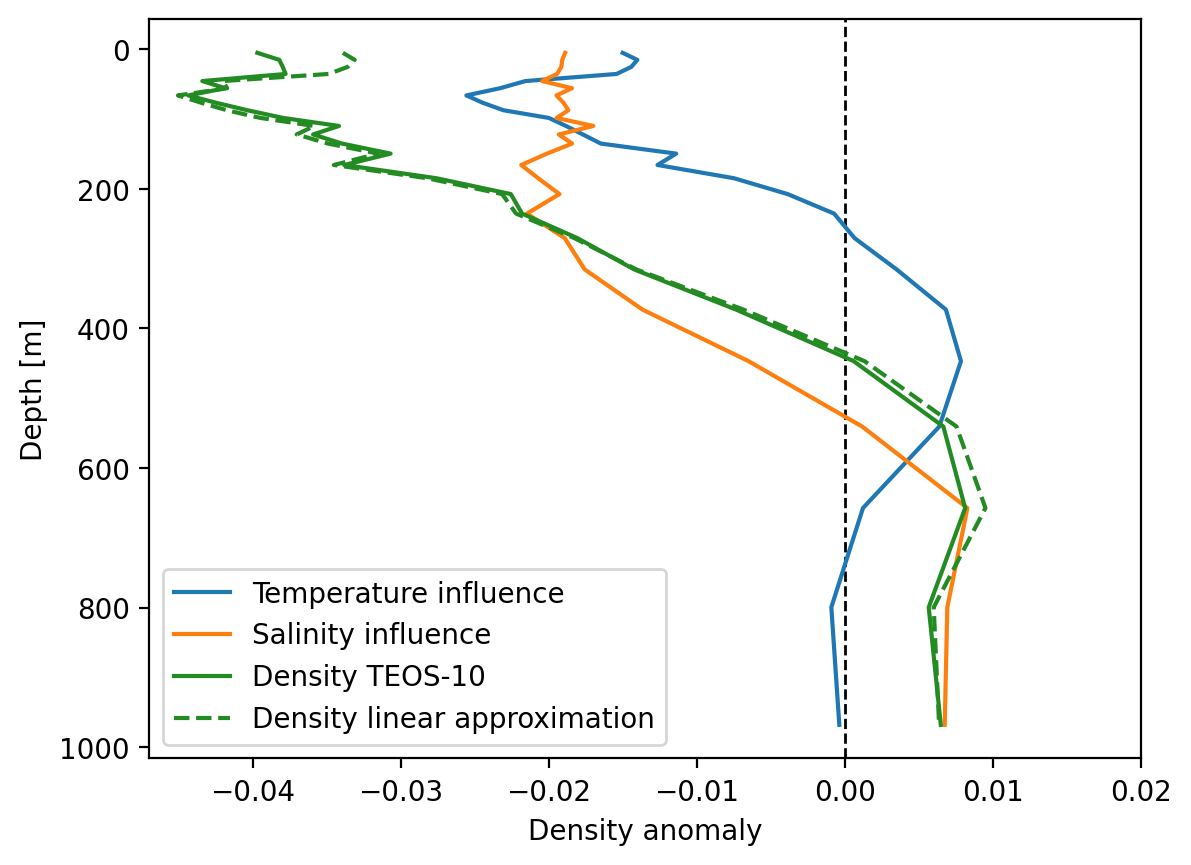

In [18]:
prof_temp = pd.read_csv('/Users/sbult/Desktop/Scripts/data/tide gauges/temp_data.csv',index_col=0)
prof_sal = pd.read_csv('/Users/sbult/Desktop/Scripts/data/tide gauges/sal_data.csv',index_col=0)
prof_ar = prof_temp.to_numpy()
prof_ar2 = prof_sal.to_numpy()
maxst_temp = prof_ar[0,:]
maxinst_temp = prof_ar[2,:]
maxst_sal = prof_ar2[0,:]
maxinst_sal = prof_ar2[2,:]

drho_t = -maxst_temp * alpha 
drho_s = maxst_sal * beta 

drho_t_in = -maxinst_temp * alpha 
drho_s_in = maxinst_sal * beta 

drho = (drho_t + drho_s)
drho_in = (drho_t_in + drho_s_in)

#perc_t = np.abs(drho_t/drho) * 100
#perc_s = np.abs(drho_s/drho) * 100
#perc = perc_t + perc_s
#elif np.any(drho) > 0:
    
plt.axvline(0,color='k',ls='--',lw=1)
plt.plot(drho_t,depth[0:26],label='Temperature influence');
plt.plot(drho_s,depth[0:26],label='Salinity influence');
plt.plot(prof[0,:],depth[0:26],label='Density TEOS-10',color='forestgreen');
plt.plot(drho,depth[0:26],label='Density linear approximation',color='forestgreen',ls='--');

plt.gca().invert_yaxis();
plt.xlabel('Density anomaly')
plt.ylabel('Depth [m]')
plt.legend();
plt.xlim([-0.047,0.02]);

#plt.savefig('/Users/sbult/Desktop/Scripts/data/StericDataSterre/contribution_to_steric_maxsteric.png', dpi=150)

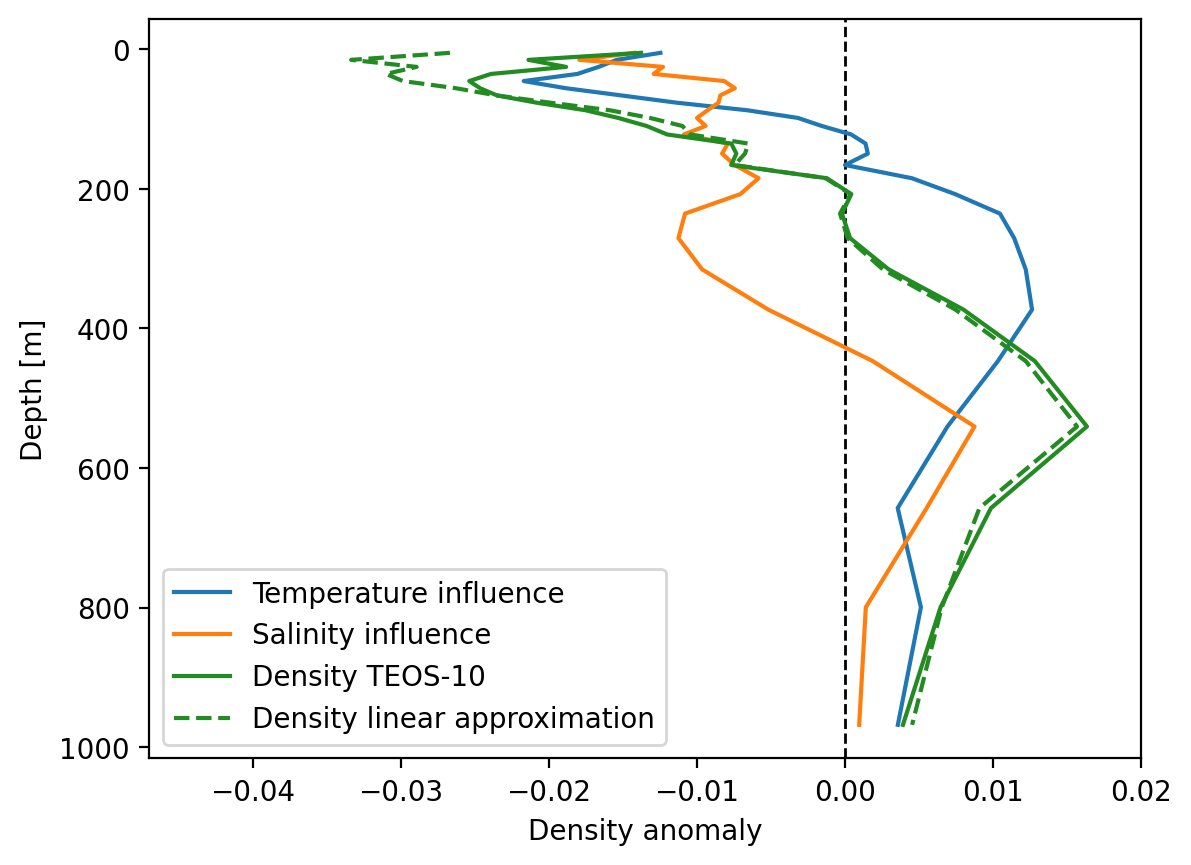

In [19]:
plt.axvline(0,color='k',ls='--',lw=1)
plt.plot(drho_t_in,depth[0:26],label='Temperature influence');
plt.plot(drho_s_in,depth[0:26],label='Salinity influence');
plt.plot(prof[2,:],depth[0:26],label='Density TEOS-10',color='forestgreen');
plt.plot(drho_in,depth[0:26],label='Density linear approximation',color='forestgreen',ls='--');

plt.gca().invert_yaxis();
plt.xlabel('Density anomaly')
plt.ylabel('Depth [m]')
plt.legend();
plt.xlim([-0.047,0.02]);

#plt.savefig('/Users/sbult/Desktop/Scripts/data/StericDataSterre/contribution_to_steric_maxinsteric.png', dpi=150)

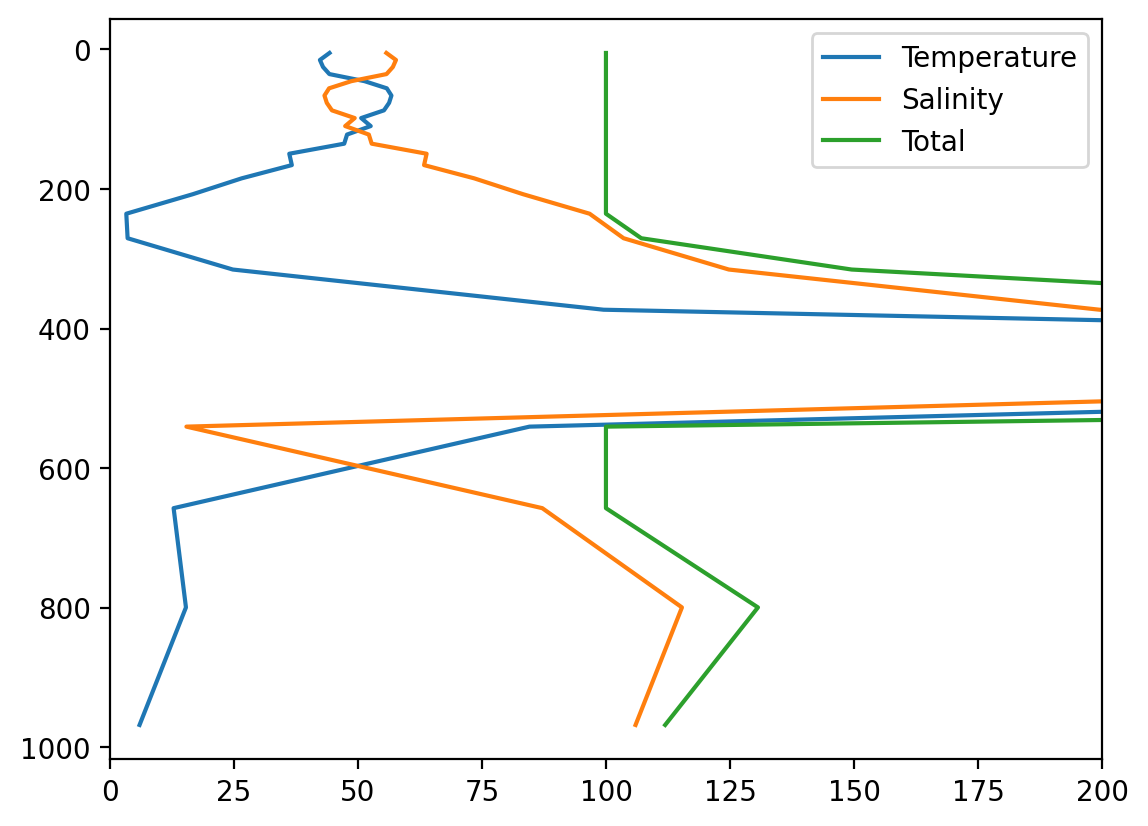

In [155]:
plt.plot(perc_t,sumdens2['depth'],label='Temperature')
plt.plot(perc_s,sumdens2['depth'],label='Salinity')
plt.plot(perc,sumdens2['depth'],label='Total')
plt.legend()
plt.xlim([0,200])
plt.gca().invert_yaxis();

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


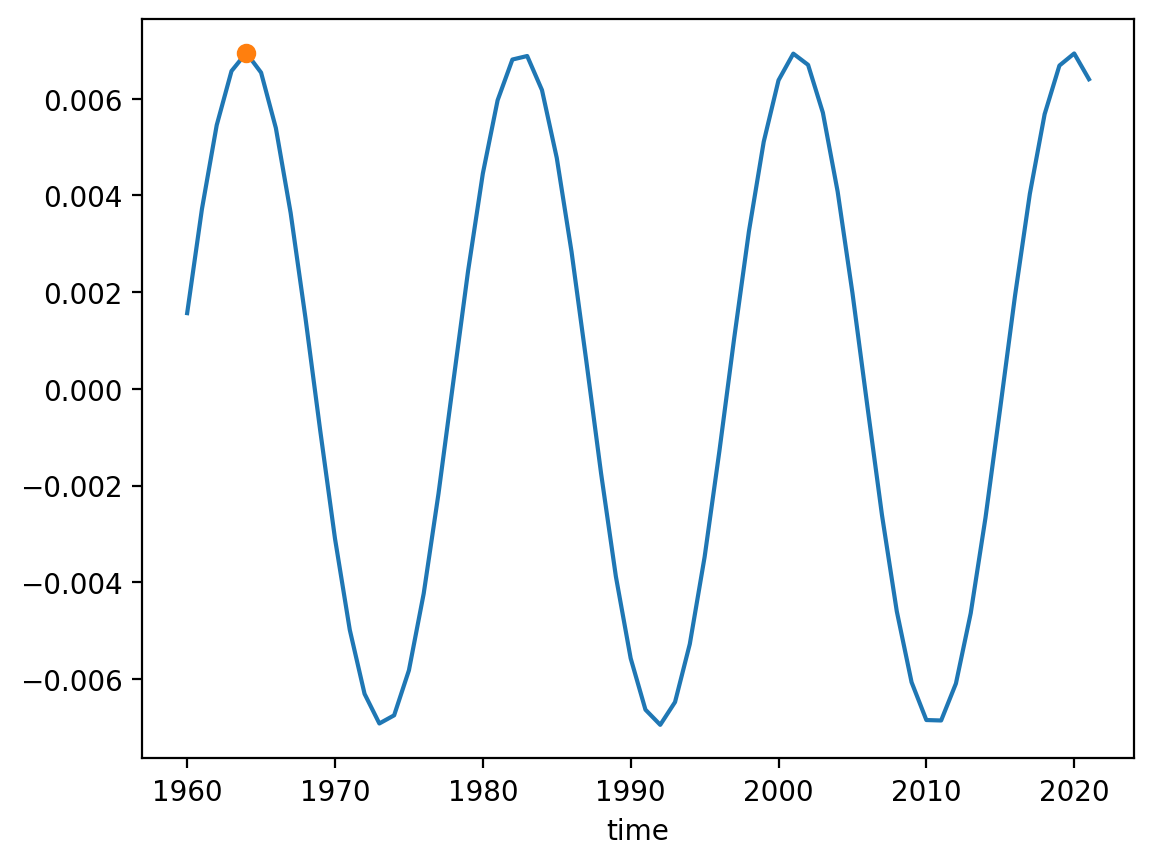

In [14]:
mask = slc.steric_masks_north_sea(density, 'EBB')
SumDens = (density * mask).mean(dim=['lat', 'lon'])
#t = SumDens.time

#SumDens = density[:,0:32,15,18]

sumdens2 = SumDens[:,0:26]

new = sumdens2.loc[1960:2021]
t = new.time

nodal = np.zeros((len(t),26))

for i in range(26):
    reg_df = new[:,i].to_dataframe()
    del reg_df['depth']

    reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
    reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)
    #del reg_df['lat']
    #del reg_df['lon']
    
    reg_df.columns = ['Steric','nod1','nod2']

    res_nr, res_full_nr = compute_model(reg_df)

    trend = res_nr.trend.iloc[0]

    res_nr['total'] = res_nr['total'] - res_nr['trend']
    nodal[:,i] = res_nr['total']
res_nr['total'].plot()
plt.plot(res_nr['total'].idxmax(),res_nr['total'].max(),'o')


#for i in range(26):
 #   dens = sumdens2[:,i]
  #  reg_df = dens.to_dataframe()
   # del reg_df['depth']
    
   # reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
    #reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)
    #reg_df.columns = ['Steric','nod1','nod2']
        
    #res_nr, res_full_nr = compute_model(reg_df)
    #res_nr['trend'].plot()
    #nodal[:,i] = res_nr['nodal_steric']

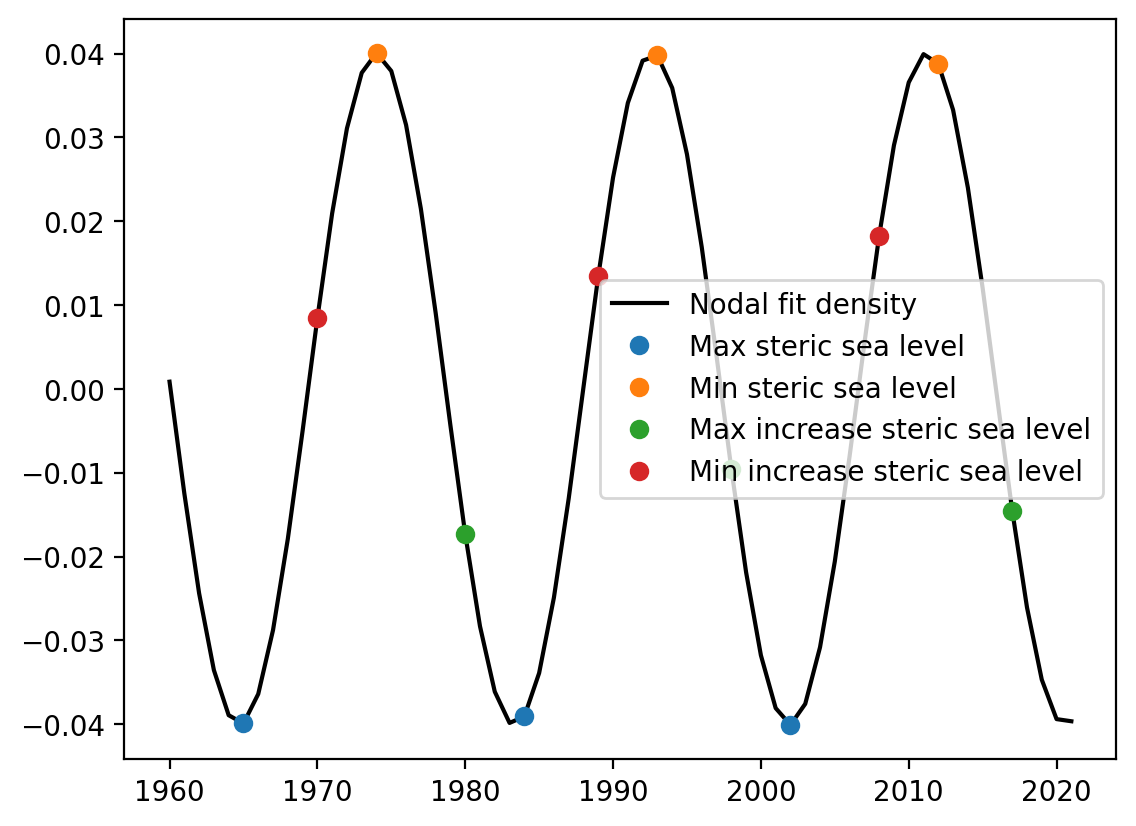

In [15]:
import scipy as sc

steric = pd.read_csv('/Users/sbult/Desktop/Scripts/data/tide gauges/nodal_steric.csv',index_col=0)
steric = steric.loc[1960:2020]

prof = np.zeros((4,26))

for i in range(26):
    der = steric.diff()

    peaks, _ = sc.signal.find_peaks(steric.values.flatten())
    troughs, _ = sc.signal.find_peaks(-steric.values.flatten())
    diff_max, _ = sc.signal.find_peaks(der.values.flatten())
    diff_min, _ = sc.signal.find_peaks(-der.values.flatten())
        
    prof[0,i] = nodal[peaks,i].mean()    
    prof[1,i] = nodal[troughs,i].mean() 
    prof[2,i] = nodal[diff_max,i].mean() 
    prof[3,i] = nodal[diff_min,i].mean() 

plt.plot(t,nodal[:,0],'k',label='Nodal fit density');
plt.plot(t[peaks],nodal[peaks,0],'o',label='Max steric sea level');
plt.plot(t[troughs],nodal[troughs,0],'o',label='Min steric sea level');
plt.plot(t[diff_max],nodal[diff_max,0],'o',label='Max increase steric sea level');
plt.plot(t[diff_min],nodal[diff_min,0],'o',label='Min increase steric sea level');
plt.legend();

#plt.savefig('/Users/sbult/Desktop/Scripts/data/StericDataSterre/Density_peaks_EN4.png', dpi=150)

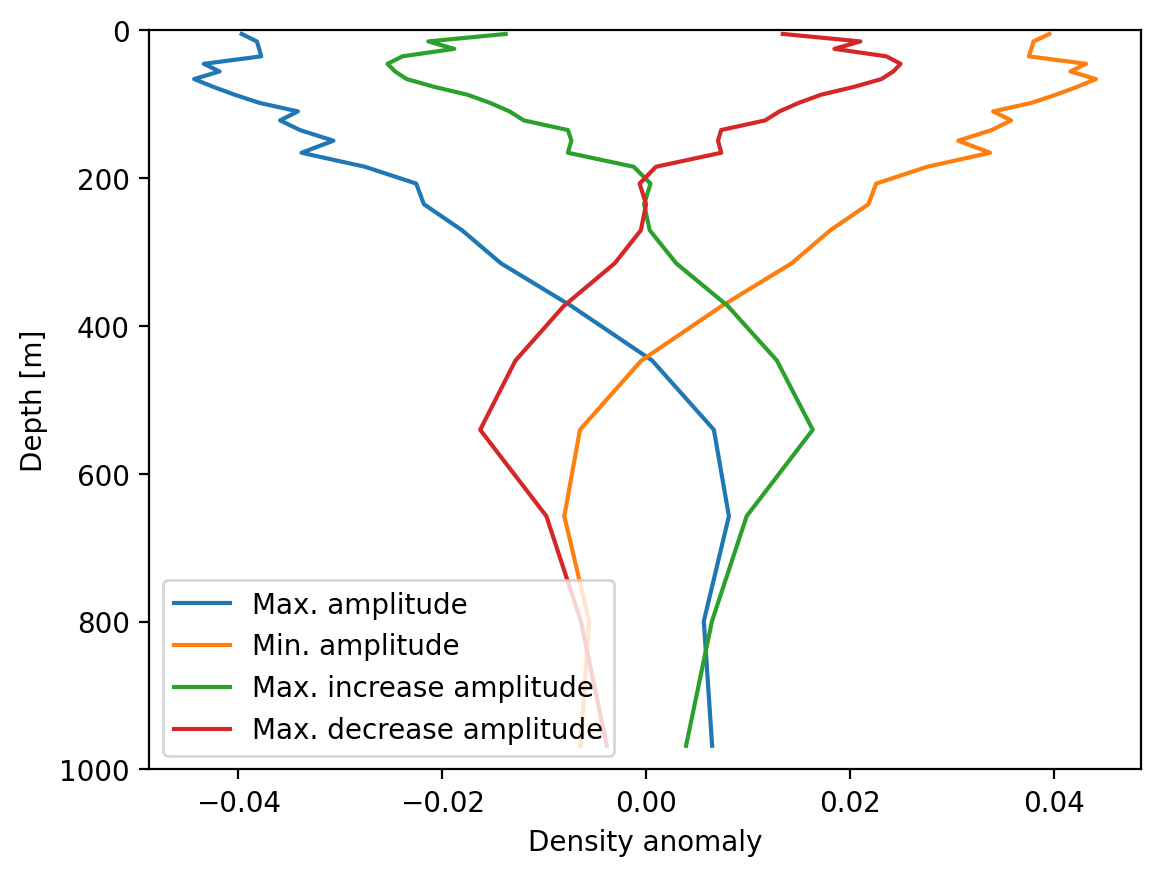

In [22]:
for i in range(0,4):
    plt.plot(prof[i,:],sumdens2['depth']);
plt.gca().invert_yaxis();
#plt.xlim([1026.1, 1028.5]);
#plt.xlim([1030,1032])
plt.ylim([1000,0]);
plt.ylabel('Depth [m]')
plt.xlabel('Density anomaly')
plt.legend(['Max. amplitude','Min. amplitude','Max. increase amplitude', 'Max. decrease amplitude']);

#plt.savefig('/Users/sbult/Desktop/Scripts/data/StericDataSterre/profiles_EBB_EN4.png', dpi=150)

<xarray.DataArray 'density' (time: 122, depth: 26)>
array([[1026.15974516, 1026.24869988, 1026.34801749, ..., 1030.12917881,
        1030.89822207, 1031.79005704],
       [1026.16044513, 1026.25502461, 1026.35411873, ..., 1030.1361037 ,
        1030.90503197, 1031.79600827],
       [1026.17155719, 1026.25212109, 1026.35126392, ..., 1030.13322267,
        1030.90436707, 1031.79540754],
       ...,
       [1026.13604743, 1026.22162828, 1026.32440296, ..., 1030.09888797,
        1030.88108947, 1031.78395412],
       [1025.9874513 , 1026.07636447, 1026.19759624, ..., 1030.1232671 ,
        1030.89187359, 1031.78750438],
       [1026.06462284, 1026.16324873, 1026.2712595 , ..., 1030.1328092 ,
        1030.90170421, 1031.80286613]])
Coordinates:
  * depth    (depth) float32 5.022 15.08 25.16 35.28 ... 540.5 657.3 799.5 968.0
  * time     (time) int64 1900 1901 1902 1903 1904 ... 2017 2018 2019 2020 2021


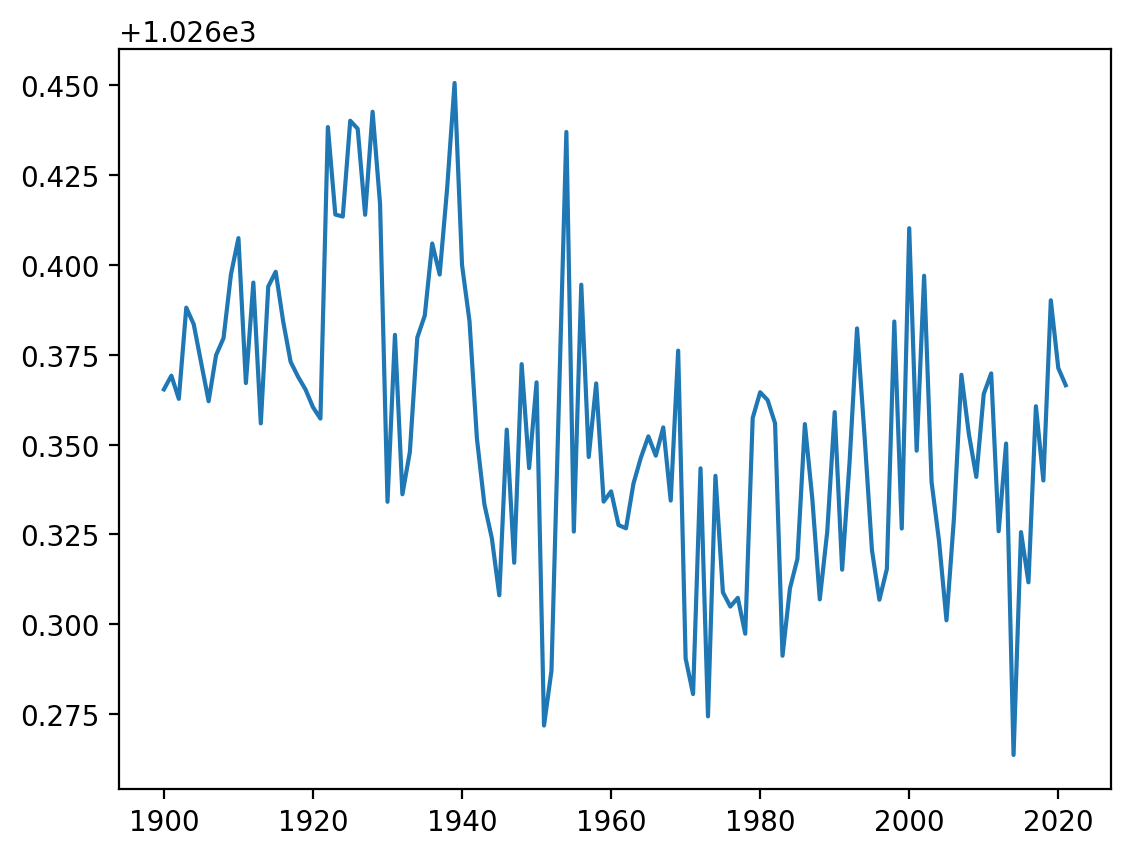

In [17]:
import scipy as sc
from scipy import signal

print(sumdens2)

t = sumdens2.time
df_detrend = sc.signal.detrend(sumdens2)
df_new = pd.DataFrame(df_detrend,index=t) + 1026
df_new[1].plot();

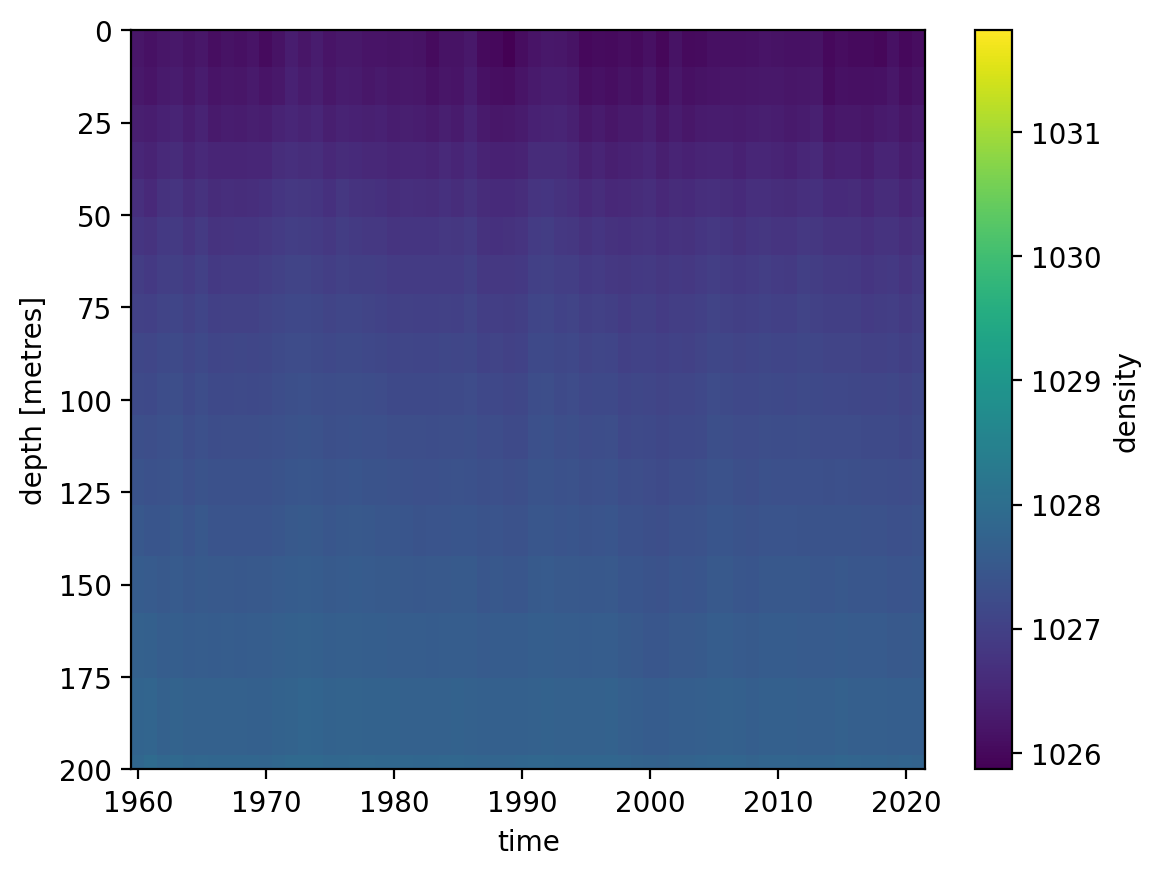

In [43]:
#for i in range(10):
 #   sumdens2[i+20,:].plot();

sumdens2 = sumdens2.loc[1960:2021]

#mean = sumdens2.mean(dim='depth')
#mean = mean.mean(dim='time')

#sumdens2 = sumdens2 - mean

(sumdens2[:,:]).plot(y='depth')
#sumdens2[-17,:].plot(y='depth',label=int(sumdens2[-22,:].time))
#sumdens2[-29,:].plot(y='depth',label=int(sumdens2[-29,:].time))
    
#plt.xlim([1025.9, 1028])

plt.ylim([0,200]);
plt.gca().invert_yaxis()

#plt.legend();

#plt.savefig('/Users/sbult/Desktop/Scripts/data/StericDataSterre/density_overview_200m.pdf', dpi=150)

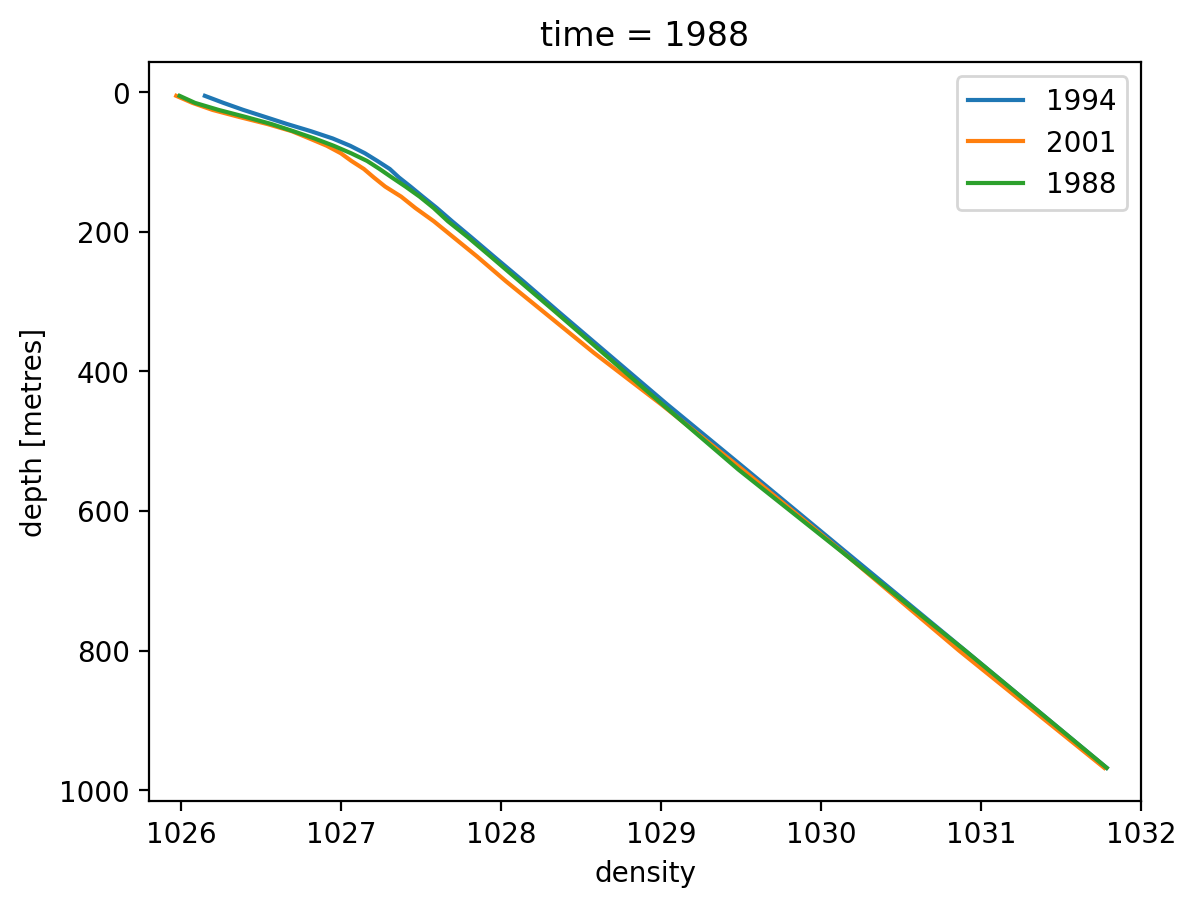

In [44]:
sumdens2[-28,:].plot(y='depth',label=int(sumdens2[-28,:].time))
sumdens2[-21,:].plot(y='depth',label=int(sumdens2[-21,:].time))
sumdens2[-34,:].plot(y='depth',label=int(sumdens2[-34,:].time))
    
plt.xlim([1025.8, 1032])
#plt.ylim([0,200]);
plt.gca().invert_yaxis()
plt.legend();

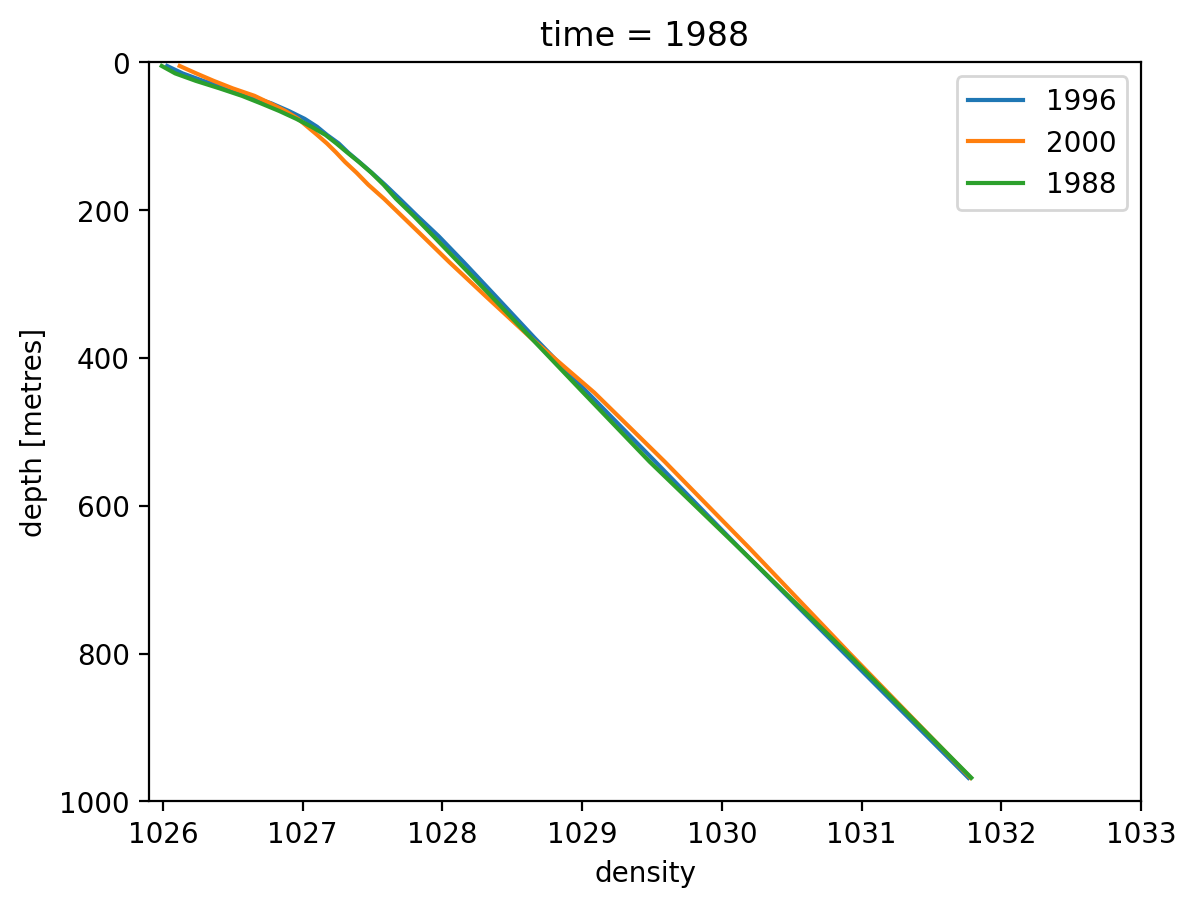

In [45]:
sumdens2[-26,:].plot(y='depth',label=int(sumdens2[-26,:].time))
sumdens2[-22,:].plot(y='depth',label=int(sumdens2[-22,:].time))
sumdens2[-34,:].plot(y='depth',label=int(sumdens2[-34,:].time))
    
plt.xlim([1025.9, 1033])
plt.ylim([0,1000]);
plt.gca().invert_yaxis()
plt.legend();

In [62]:
t =  sumdens2.time;
ampl_iap = np.zeros(26)
norm_nodal = np.zeros((len(t),26))

for i in range(26):
    ampl_iap[i] = (nodal[:,i].max() - nodal[:,i].min())/2
    #norm_nodal[:,i] = (nodal[:,i] - nodal[:,i].max())/nodal[:,i].max()

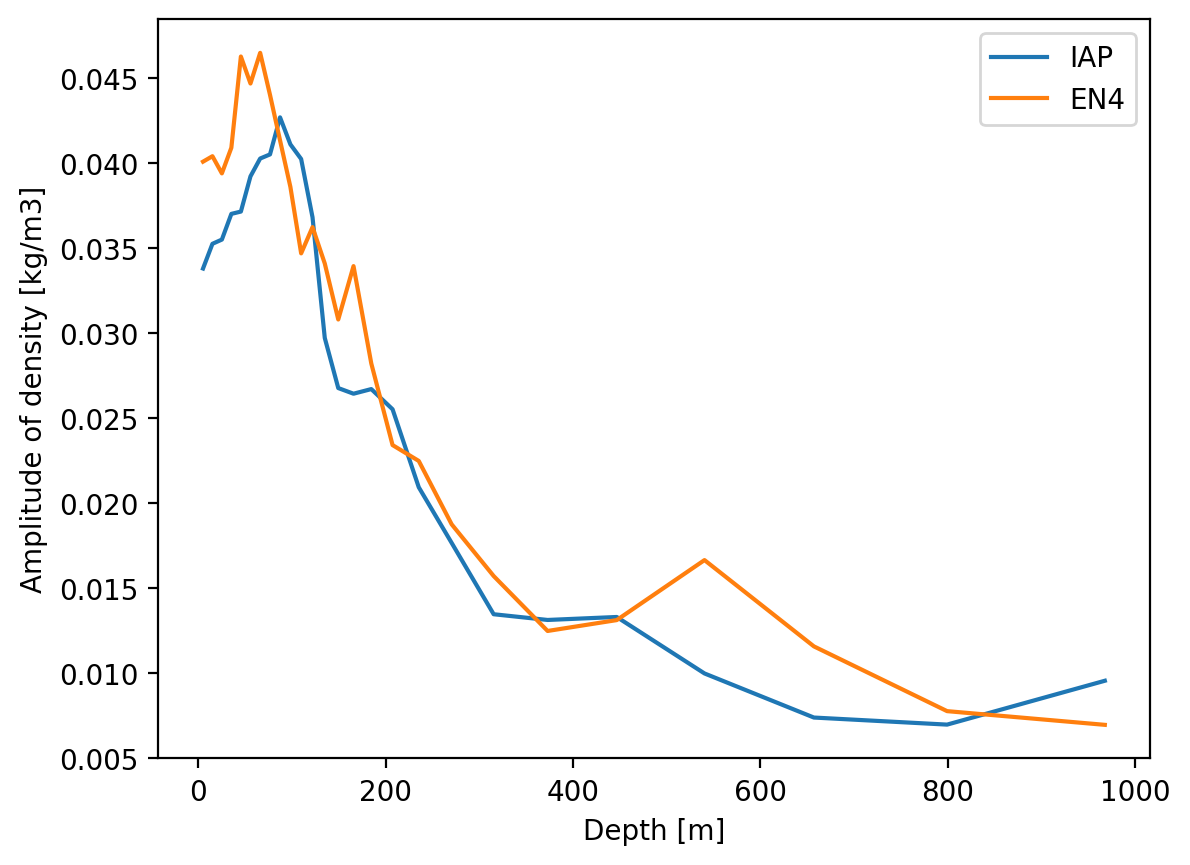

In [53]:
plt.plot(depth[0:26],ampl_iap,label='IAP')
plt.plot(depth[0:26],ampl,label='EN4')
plt.ylabel('Amplitude of density [kg/m3]')
plt.xlabel('Depth [m]');
plt.legend();

#plt.savefig('/Users/sbult/Desktop/Scripts/data/StericDataSterre/amplitude_density.png', dpi=150)

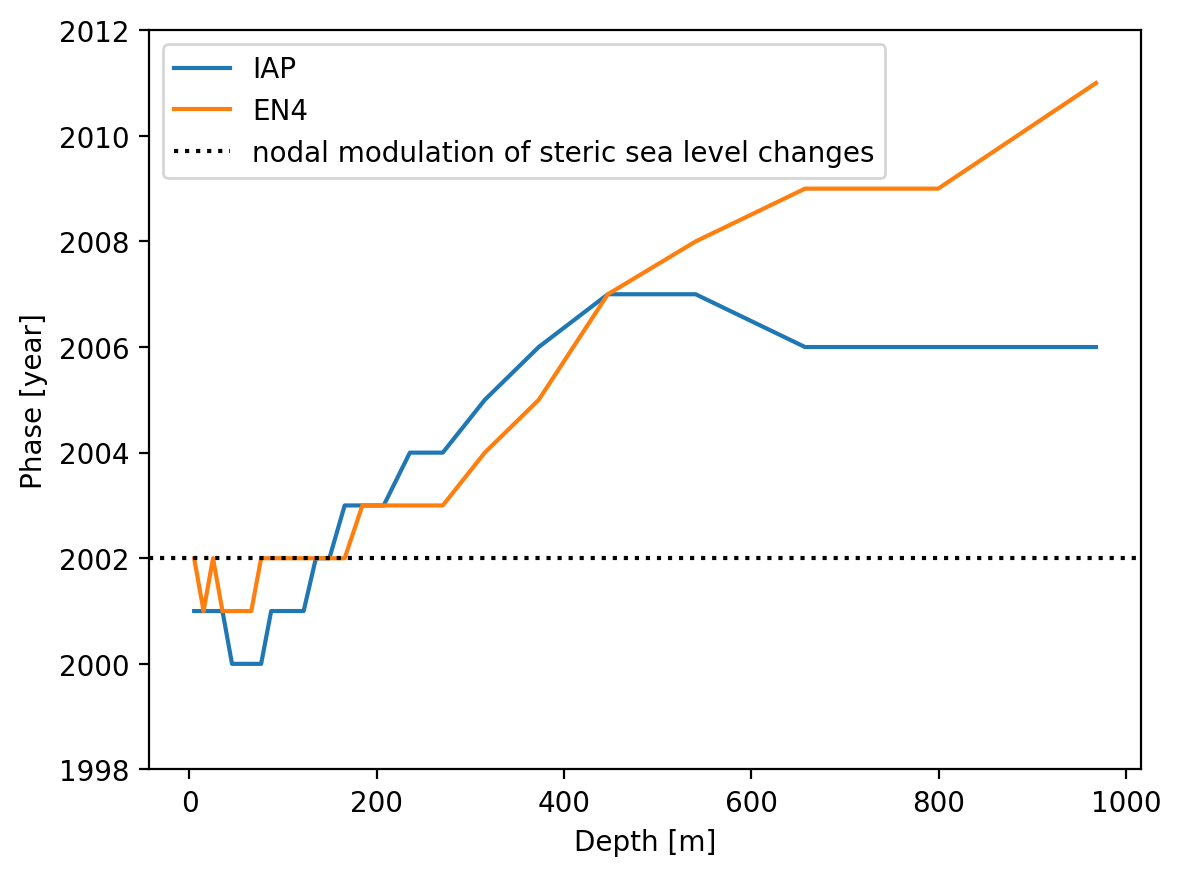

In [80]:
phase_iap = np.zeros(26)

t =  sumdens2.time.loc[1960:2021];
#nodal = nodal[33:52,:]

#plt.plot(t,nodal[:,1])

for i in range(26):
    phase_iap[i] = t[int(nodal[:,i].argmin())] + 33
    #plt.plot(sumdens2['depth'][i],t[int(phase[i])],'bo',label='EN4')
    
plt.plot(depth[0:26],phase_iap,label='IAP')
plt.plot(depth[0:26],phase,label='EN4')

plt.axhline(2002,color='k',linestyle=':',label='nodal modulation of steric sea level changes')
plt.ylim([1998,2012]);
plt.ylabel('Phase [year]')
plt.xlabel('Depth [m]');
plt.legend(loc='upper left');

#plt.savefig('/Users/sbult/Desktop/Scripts/data/StericDataSterre/phase_density.png', dpi=150)

(62, 32)


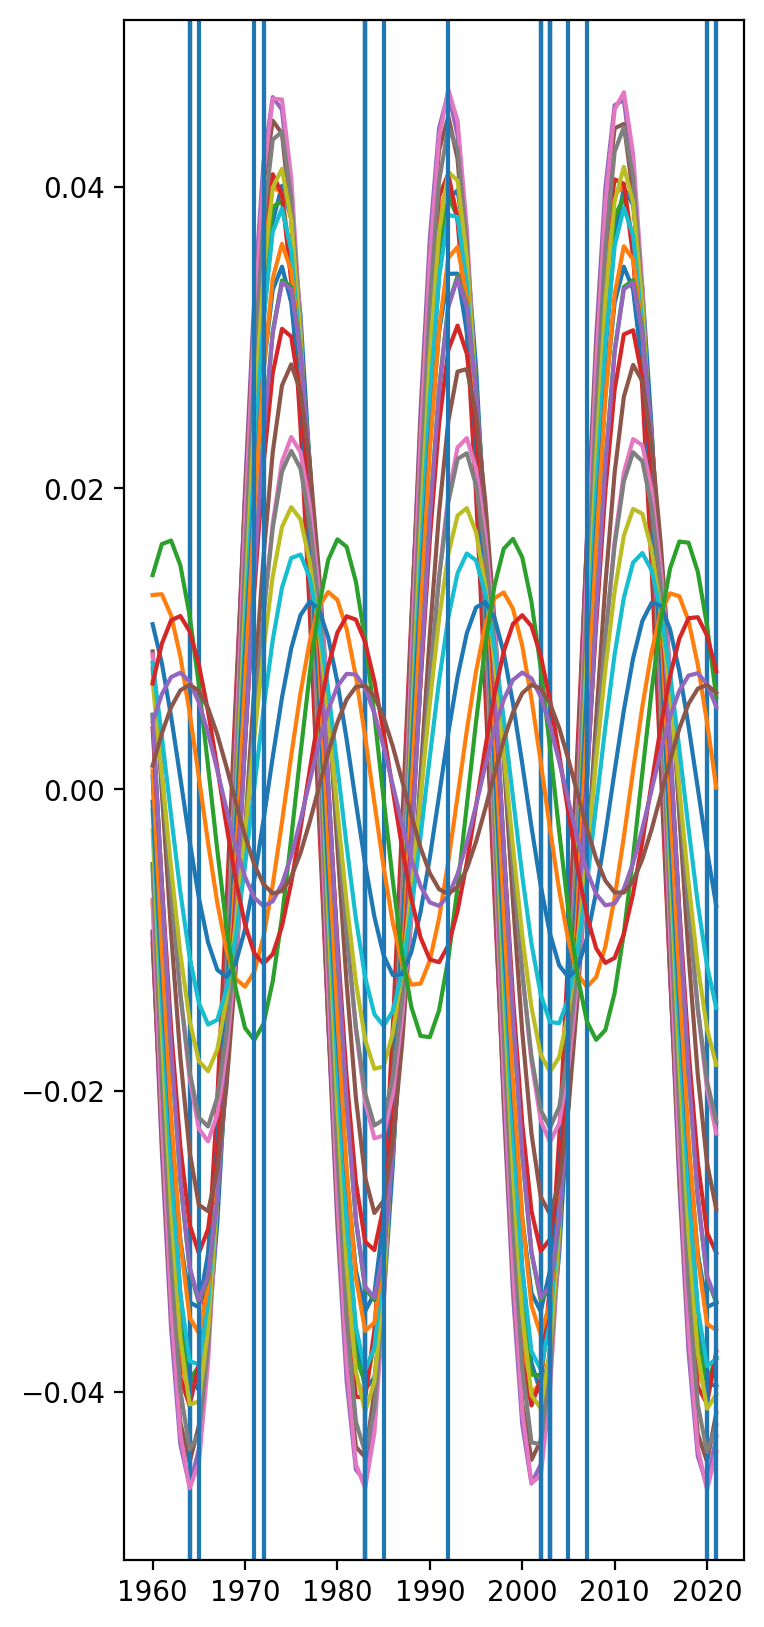

In [22]:
print(np.shape(nodal))
plt.figure(figsize=(4,10))
for i in range(26):
    plt.plot(t,nodal[:,i]);
    plt.axvline(t[nodal[:,i].argmin()])

In [23]:
depth_iap = sumdens2['depth']

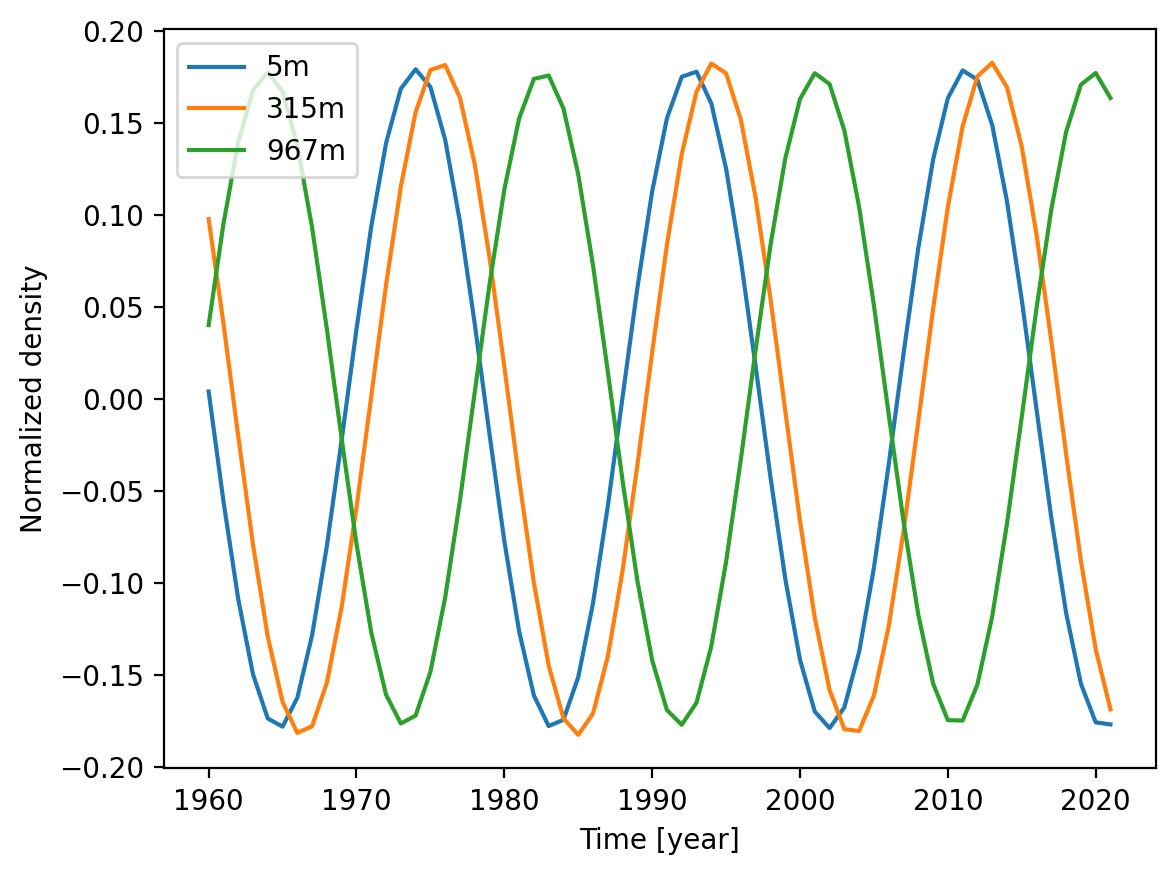

In [24]:
from sklearn import preprocessing

norm_nodal = np.zeros((62,26))

for i in range(26):
    norm_nodal[:,i] = preprocessing.normalize([nodal[:,i]])

plt.plot(t,norm_nodal[:,0],label=str(int(sumdens2.depth[0]))+'m')
plt.plot(t,norm_nodal[:,19],label=str(int(sumdens2.depth[19]))+'m')
plt.plot(t,norm_nodal[:,25],label=str(int(sumdens2.depth[25]))+'m');
plt.legend()
plt.xlabel('Time [year]')
plt.ylabel('Normalized density');

#plt.savefig('/Users/sbult/Desktop/Scripts/data/StericDataSterre/phase_density_depths.pdf', dpi=150)

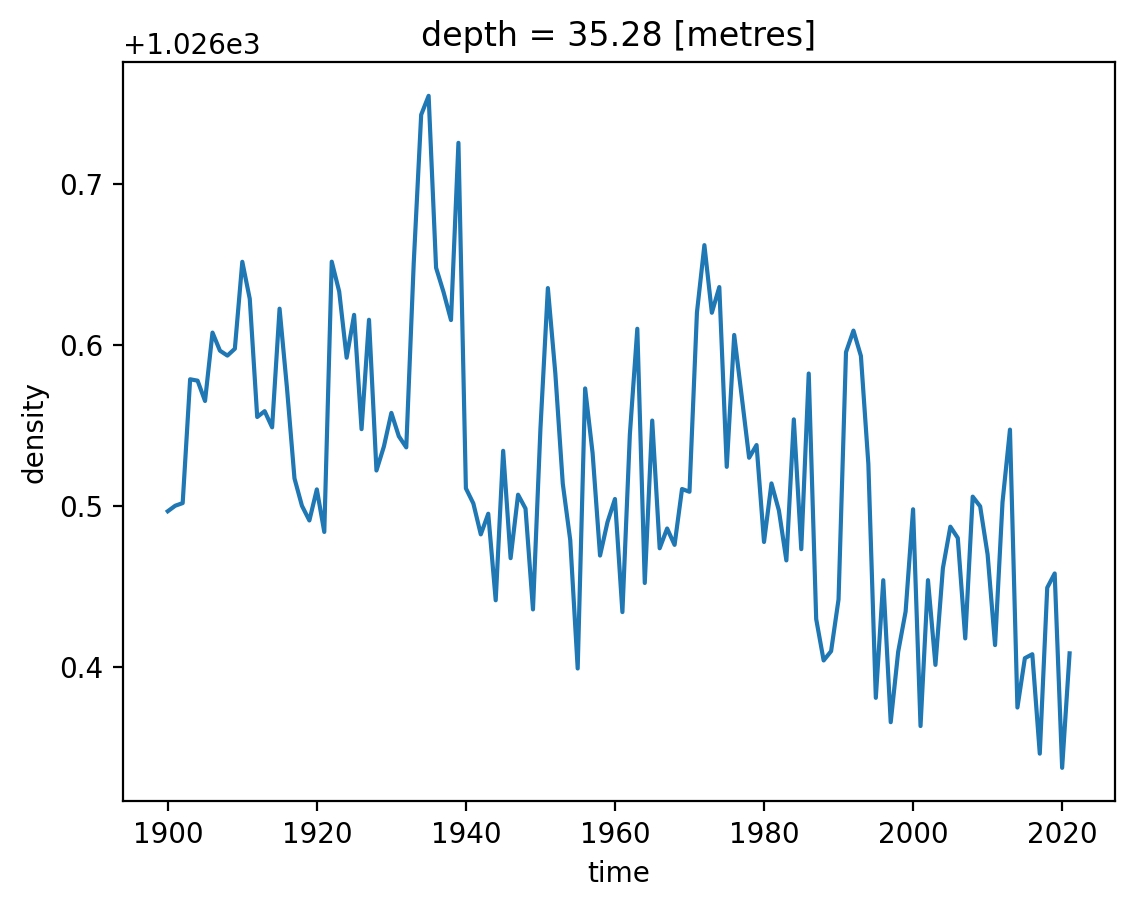

In [25]:
SumDens[:,3].plot();

In [26]:
#peaks, props = sc.signal.find_peaks(res_nr['total'])
#peaks2 = [peaks[0]-1,peaks[0],peaks[0]+1,peaks[1]-1,peaks[1],peaks[1]+1,peaks[2]-1,peaks[2],peaks[2]+1]
#mean_peak = np.mean(res_nr['total'].iloc[peaks2])
#print(mean_peak)
#troughs, props2 = sc.signal.find_peaks(-res_nr['total'])
#troughs2 = [troughs[0]-1,troughs[0],troughs[0]+1,troughs[1]-1,troughs[1],troughs[1]+1,troughs[2]-1,troughs[2],troughs[2]+1]
#plt.plot(res_nr['total'].iloc[peaks2],'o')
#plt.plot(res_nr['total'].iloc[troughs2],'o')

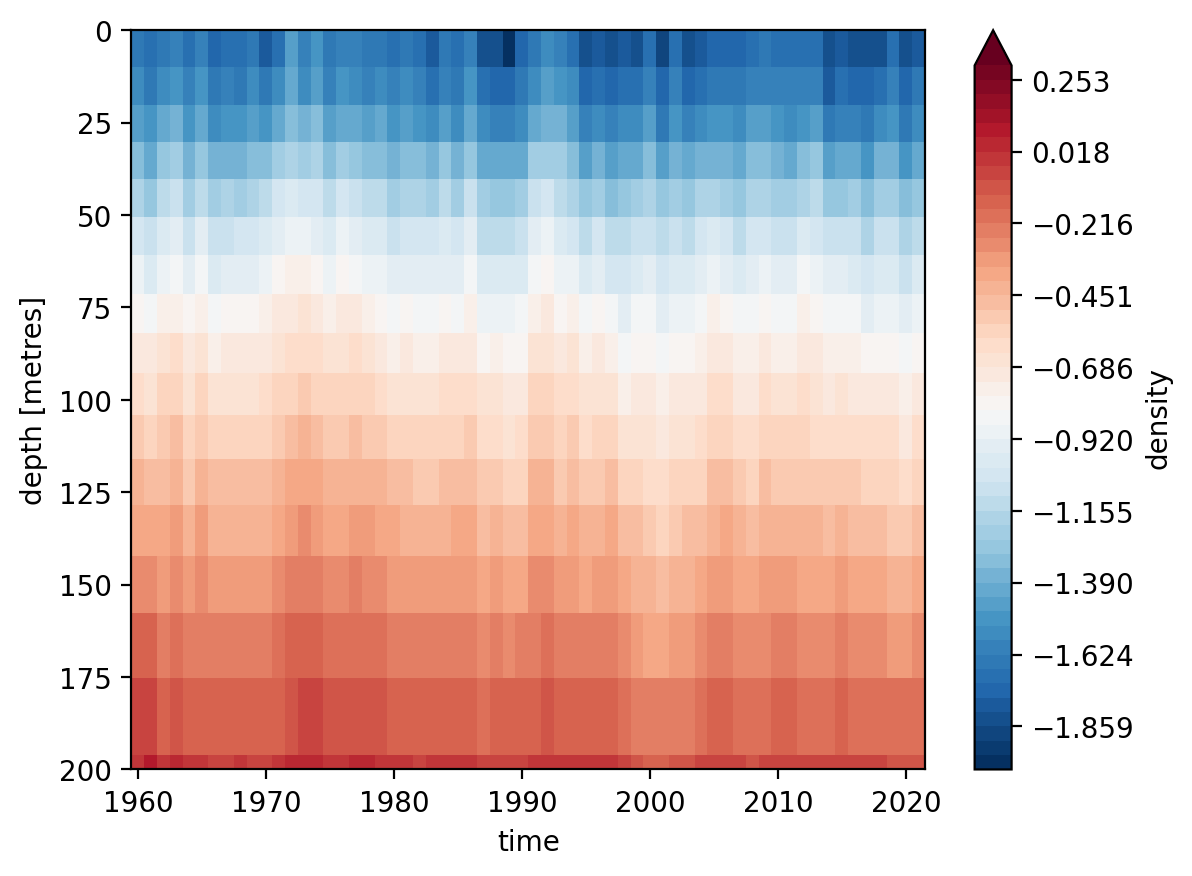

In [27]:
(sumdens2[:,0:26]-sumdens2[:,0:26].mean()).plot(y='depth',levels=np.linspace(-2,0.3))

plt.ylim([0,200]);
plt.gca().invert_yaxis()

#plt.savefig('/Users/sbult/Desktop/Scripts/data/StericDataSterre/density_overview_200m_anomaly.pdf', dpi=150)